In [2]:
import os, copy
import numpy as NP
import numpy.linalg as LA
import scipy.optimize as OPT
import astropy.constants as FCNST
from astropy import units as U
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.modeling import models, fitting
import matplotlib as MPL
import matplotlib.pyplot as PLT
import matplotlib.colors as PLTC
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Arc, RegularPolygon
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, InsetPosition
from astroutils import geometry as GEOM
try:
    from pyuvdata import UVData
except ImportError:
    pyuvdata_found = False
else:
    pyuvdata_found = True

from IPython.core.debugger import set_trace
%matplotlib notebook

os.environ["PATH"] += os.pathsep + '/opt/local/bin/'

MPL.rcParams['xtick.direction'] = 'in'
MPL.rcParams['ytick.direction'] = 'in'

MPL.rc('text', usetex=True)
MPL.rc('font', **{'size': 12,'family': 'serif', 'serif': ['Computer Modern']})

# Define some useful functions

In [4]:
def gaussian2D_without_offset(xy_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (NP.cos(theta)**2)/(2*sigma_x**2) + (NP.sin(theta)**2)/(2*sigma_y**2)
    b = -(NP.sin(2*theta))/(4*sigma_x**2) + (NP.sin(2*theta))/(4*sigma_y**2)
    c = (NP.sin(theta)**2)/(2*sigma_x**2) + (NP.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*NP.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def gaussian2D_with_offset(xy_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (NP.cos(theta)**2)/(2*sigma_x**2) + (NP.sin(theta)**2)/(2*sigma_y**2)
    b = -(NP.sin(2*theta))/(4*sigma_x**2) + (NP.sin(2*theta))/(4*sigma_y**2)
    c = (NP.sin(theta)**2)/(2*sigma_x**2) + (NP.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*NP.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def herons_formula(a, b, c):
    s = 0.5 * (a + b + c)
    return NP.sqrt(s*(s-a)*(s-b)*(s-c))

## Perform some IERS related adjustments

In [5]:
# from astropy.utils import iers

# default_iers_auto_url = 'http://maia.usno.navy.mil/ser7/finals2000A.all'
# secondary_iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'

# try:    
# #     iers.conf.iers_auto_url = default_iers_auto_url
#     iers.conf.remote_timeout = 100.0
#     iers.IERS_A.open(iers.IERS_A_URL)
# except Exception as err:
#     if ('url' in str(err).lower()) or (('connection' in str(err).lower())):
#         print(err)
#         print('Original source URL for IERS_A: {0} failed!'.format(iers.conf.iers_auto_url))
#         print('Original IERS Configuration:')
#         print(iers.conf.__class__.__dict__)
#         print('Modifying the source URL for IERS_A table to {0}'.format(secondary_iers_auto_url))
# #         iers.IERS_A_URL = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
#         iers.conf.auto_download = True
#         iers.conf.iers_auto_url = secondary_iers_auto_url
# #         iers.conf.iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
#         try:
#             print('Now testing {0}'.format(secondary_iers_auto_url))
#             iers_a = iers.IERS_A.open(secondary_iers_auto_url)
#         except Exception as newerr:
#             if ('url' in str(err).lower()):
#                 print(newerr)
#                 print('Modified URL also did not work. Computation of LST may be affected or will completely fail.')
# #                 raise newerr
#         else:
#             print('Updated source URL {0} worked!'.format(secondary_iers_auto_url))
#             print('Modified IERS Configuration:')
#             print(iers.conf.__class__.__dict__)

# Work on EHT M87 data

## Set up folders

In [6]:
projectdir = '/lustre/aoc/users/nthyagar/projects/CPhaseGeom/'
datadir = projectdir + 'data/'
figdir = projectdir + 'figures/'
imgdir_M87 = datadir + 'EHT/M87/image/'
visdir_M87 = datadir + 'EHT/M87/UV/'
visfile_M87 = '1minRRsc.uvfits'

# Read visibility information

In [7]:
f0 = 229.070696646 * 1e9 * U.Hz # center frequency
wl0 = FCNST.c / f0
antenna_names = ['ALMA', 'LMT', 'SMA']
antnum = [1, 5, 7]
antpairs = [(antnum[i],antnum[(i+1)%3]) for i in range(len(antenna_names))]
uvw_data = 1e3 * NP.asarray([[1795053.0, -3074671.0, 0.0], 
                             [6229150.0, -3266290.0, 0.0], 
                             [4434132.0, -191633.0, 0.0]])
# uvw_data = 1e3 * NP.asarray([[6229150.0, -3266290.0, 0.0], 
#                              [1795053.0, -3074671.0, 0.0], 
#                              [4434132.0, -191633.0, 0.0]])
uvvect_data = uvw_data
blvect_data = uvw_data * wl0
bll_data = NP.sqrt(NP.sum(blvect_data**2, axis=1))
fringe_slopes_data = -uvw_data[:,0] / uvw_data[:,1]
vis_snr = 3.0
phase_err = 1/vis_snr # in radians
pos_err = phase_err / (2 * NP.pi * NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1))) # in radians

In [8]:
print(wl0.to('m'))
print(antenna_names)
print(antpairs)
print(blvect_data.to('km'))
print(bll_data.to('km'))
print(uvvect_data)
print(NP.sqrt(NP.sum(uvvect_data**2, axis=1)))
print(1/NP.sqrt(NP.sum(uvvect_data**2, axis=1)))
print(NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)))
print(1/NP.sqrt(NP.sum(uvvect_data[:,:2]**2, axis=1)))
print(fringe_slopes_data)
print(vis_snr)
print(phase_err)
print(NP.degrees(pos_err) * 3.6e3 * 1e6) # in uas

0.001308733340359512 m
['ALMA', 'LMT', 'SMA']
[(1, 5), (5, 7), (7, 1)]
[[ 2349.24570881 -4023.92444834     0.        ]
 [ 8152.2962871  -4274.70262228     0.        ]
 [ 5803.09638396  -250.79649621     0.        ]] km
[4659.49818825 9205.05389781 5808.51328   ] km
[[ 1.795053e+09 -3.074671e+09  0.000000e+00]
 [ 6.229150e+09 -3.266290e+09  0.000000e+00]
 [ 4.434132e+09 -1.916330e+08  0.000000e+00]]
[3.56031137e+09 7.03355956e+09 4.43827104e+09]
[2.80874310e-10 1.42175522e-10 2.25312963e-10]
[3.56031137e+09 7.03355956e+09 4.43827104e+09]
[2.80874310e-10 1.42175522e-10 2.25312963e-10]
[ 0.58381954  1.90710255 23.1386661 ]
3.0
0.3333333333333333
[3.0735199  1.55578235 2.46552942]


# Read and plot synthesis image

In [9]:
rawimgfilename = '229RAW.FITS'
# synimgfilename = '229RNG.FITS'
synimgfilename = '229F.FITS'

try:
    with fits.open(imgdir_M87+synimgfilename, mode='readonly') as hdul:
        synimghdr = hdul[0].header
        synimgdata = hdul[0].data
except IOError as err:
    print(err) 
    
try:
    with fits.open(imgdir_M87+rawimgfilename, mode='readonly') as hdul:
        rawimghdr = hdul[0].header
        rawimgdata = hdul[0].data
except IOError as err:
    print(err) 

<IPython.core.display.Javascript object>


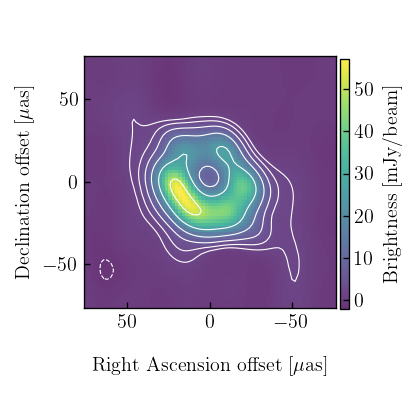

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_selfcal_image.pdf


In [10]:
wcs = WCS(synimghdr).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)[0]
cdelt = wcs.wcs.cdelt
data = 1e3 * synimgdata.squeeze()
xvals = (NP.arange(data.shape[1]) - center[0]) * cdelt[0]*3.6e3*1e6 # in uas
yvals = (NP.arange(data.shape[0]) - center[1]) * cdelt[1]*3.6e3*1e6 # in uas
xlim = [0.3 * xvals[0], 0.3*xvals[-1]] # in uas
ylim = [0.3 * yvals[0], 0.3*yvals[-1]] # in uas
synimg_rms = 1.4826 * NP.median(NP.abs(data - NP.median(data)))
gp = NP.geomspace(3.0, 96.0, 6)
cntr_levels = synimg_rms * NP.hstack((-3.0, gp))

fig, ax = PLT.subplots(nrows=1, ncols=1, squeeze=True, subplot_kw={'aspect': 'equal'}, figsize=(3.5,3.3))
img_M87 = ax.pcolorfast(xvals, yvals, data, cmap='viridis', norm=PLTC.Normalize(vmax=data.max(), vmin=data.min()), alpha=0.8)
cntr_M87 = ax.contour(xvals, yvals, data, levels=cntr_levels, linewidths=0.67, colors='white')
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.2, right=0.8, bottom=0.1, top=0.98)

cbax = fig.add_axes([0.81, 0.22, 0.02, 0.63]) 
cbar = PLT.colorbar(img_M87, cax=cbax)
cbar.set_label('Brightness [mJy/beam]', labelpad=5, y=0.5)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension offset\t'+r'[$\mu$as]', weight='medium', labelpad=0)
big_ax.set_ylabel('Declination offset\t'+r'[$\mu$as]', weight='medium', labelpad=30)

# PLT.savefig(figdir+'M87_selfcal_image.pdf', bbox_inches=0)
print(figdir+'M87_selfcal_image.pdf')

## Read and plot raw and self-calibrated images side-by-side

Synthesized image RMS: 0.515 mJy/beam


<IPython.core.display.Javascript object>


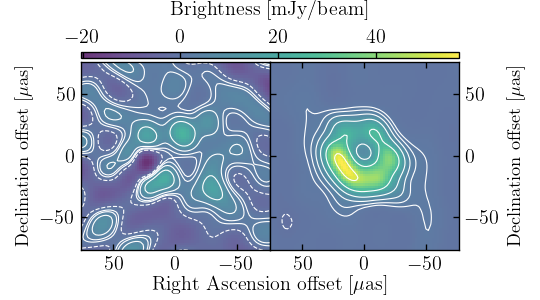

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_raw_selfcal_image.pdf


In [11]:
wcs = WCS(synimghdr).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)[0]
cdelt = wcs.wcs.cdelt
syndata = 1e3 * synimgdata.squeeze()
rawdata = 1e3 * rawimgdata.squeeze()
xvals = (NP.arange(syndata.shape[1]) - center[0]) * cdelt[0]*3.6e3*1e6 # in uas
yvals = (NP.arange(syndata.shape[0]) - center[1]) * cdelt[1]*3.6e3*1e6 # in uas
xlim = [0.3 * xvals[0], 0.3*xvals[-1]] # in uas
ylim = [0.3 * yvals[0], 0.3*yvals[-1]] # in uas
synimg_rms = 1.4826 * NP.median(NP.abs(syndata - NP.median(syndata)))
print('Synthesized image RMS: {0:.3f} mJy/beam'.format(synimg_rms))
gp = NP.geomspace(3.0, 96.0, 6)
cntr_levels = synimg_rms * NP.hstack((-3.0, gp))
data_min = NP.min([syndata.min(), rawdata.min()])
data_max = NP.max([syndata.max(), rawdata.max()])

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.5))

raw_img_M87 = axs[0].pcolorfast(xvals, yvals, rawdata, cmap='viridis', norm=PLTC.Normalize(vmax=data_max, vmin=data_min), alpha=0.8)
raw_cntr_M87 = axs[0].contour(xvals, yvals, rawdata, levels=cntr_levels, linewidths=0.67, colors='white')
axs[0].set_xlim(xlim[0], xlim[1])
axs[0].set_ylim(ylim[0], ylim[1])
axs[0].set_ylabel('Declination offset\t'+r'[$\mu$as]', fontsize=11, weight='medium')
syn_img_M87 = axs[1].pcolorfast(xvals, yvals, syndata, cmap='viridis', norm=PLTC.Normalize(vmax=data_max, vmin=data_min), alpha=0.8)
syn_cntr_M87 = axs[1].contour(xvals, yvals, syndata, levels=cntr_levels, linewidths=0.67, colors='white')
axs[1].set_xlim(xlim[0], xlim[1])
axs[1].set_ylim(ylim[0], ylim[1])
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position('right')
axs[1].tick_params(bottom=True, top=True, left=True, right=True)
axs[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)
axs[1].set_ylabel('Declination offset\t'+r'[$\mu$as]', fontsize=11, weight='medium')

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.81)

# cbax = fig.add_axes([0.88, 0.22, 0.02, 0.63]) 
# cbar = PLT.colorbar(img_M87, cax=cbax)
# cbar.set_label('Brightness [mJy/beam]', labelpad=5, y=0.5)

cbax = fig.add_axes([0.15, 0.805, 0.7, 0.02]) 
cbar = PLT.colorbar(syn_img_M87, cax=cbax, orientation='horizontal')
cbax.xaxis.tick_top()
# cbax.set_title('Brightness [mJy/beam]', fontsize=12, labelpad=15)
cbar.set_label('Brightness [mJy/beam]', labelpad=-35, x=0.5)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension offset\t'+r'[$\mu$as]', weight='medium', labelpad=12)

# PLT.savefig(figdir+'M87_raw_selfcal_image.pdf', bbox_inches=0)
print(figdir+'M87_raw_selfcal_image.pdf')

In [12]:
print(data_min)
print(data_max)
wcs = WCS(synimghdr).celestial
print(wcs)

-20.344282
57.076904
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 187.705930758  12.3911232392  
CRPIX : 128.0  129.0  
NAXIS : 256  256


# Read fringe image information (CAUTION: Have to manually match the antenna pairs from the header and the filenames)

In [13]:
imgfilenames = {'ant-pairs': antpairs, 'bl-fringes': {'cal': ['AALMsc.fits', 'AASMsc.fits', 'SMLMsc.fits'], 'uncal': ['AALMr.fits', 'AASMr.fits', 'SMLMr.fits'], 'crpt': ['AALMx.fits', 'AASMx.fits', 'SMLMx.fits']}, 'triad-fringes': {'cal': '1minRRsc.fits', 'uncal': '1minRRr.fits', 'crpt': '1minRRx.fits'}}
imghdrs = {}
imgdata = {}
for calkey in imgfilenames['bl-fringes']:
    for fname in imgfilenames['bl-fringes'][calkey]:
        try:
            with fits.open(imgdir_M87+fname, mode='readonly') as hdul:
                imghdrs[fname] = hdul[0].header
                imgdata[fname] = hdul[0].data
        except IOError as err:
            print(err)   

# Combine two fringes at a time

In [14]:
imgdata['two-fringes'] = {}
double_antpairs = {}
double_fringenames = {}
double_antpairs_fringenames = {}
for calkey in imgfilenames['bl-fringes']:
    imgdata['two-fringes'][calkey] = {}
    double_antpairs[calkey] = {}
    double_fringenames[calkey] = {}
    double_antpairs_fringenames[calkey] = []
    for fnamei,fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
        fkey_out = '{0}+{1}'.format(fname.split('.fits')[0], fname_next.split('.fits')[0])
        dbl_antpair = (imgfilenames['ant-pairs'][fnamei],imgfilenames['ant-pairs'][(fnamei+1)%3])
        print('{0} + {1} --> {2}'.format(fname, fname_next, fkey_out))
        imgdata['two-fringes'][calkey][fkey_out] = imgdata[fname] + imgdata[fname_next]
        double_fringenames[calkey][dbl_antpair] = copy.copy(fkey_out)
        double_antpairs[calkey][fkey_out] = copy.copy(dbl_antpair)
        double_antpairs_fringenames[calkey] += [(dbl_antpair, fkey_out)]
print(double_antpairs)
print(double_fringenames)
print(double_antpairs_fringenames)

AALMsc.fits + AASMsc.fits --> AALMsc+AASMsc
AASMsc.fits + SMLMsc.fits --> AASMsc+SMLMsc
SMLMsc.fits + AALMsc.fits --> SMLMsc+AALMsc
AALMr.fits + AASMr.fits --> AALMr+AASMr
AASMr.fits + SMLMr.fits --> AASMr+SMLMr
SMLMr.fits + AALMr.fits --> SMLMr+AALMr
AALMx.fits + AASMx.fits --> AALMx+AASMx
AASMx.fits + SMLMx.fits --> AASMx+SMLMx
SMLMx.fits + AALMx.fits --> SMLMx+AALMx
{'cal': {'AALMsc+AASMsc': ((1, 5), (5, 7)), 'AASMsc+SMLMsc': ((5, 7), (7, 1)), 'SMLMsc+AALMsc': ((7, 1), (1, 5))}, 'uncal': {'AALMr+AASMr': ((1, 5), (5, 7)), 'AASMr+SMLMr': ((5, 7), (7, 1)), 'SMLMr+AALMr': ((7, 1), (1, 5))}, 'crpt': {'AALMx+AASMx': ((1, 5), (5, 7)), 'AASMx+SMLMx': ((5, 7), (7, 1)), 'SMLMx+AALMx': ((7, 1), (1, 5))}}
{'cal': {((1, 5), (5, 7)): 'AALMsc+AASMsc', ((5, 7), (7, 1)): 'AASMsc+SMLMsc', ((7, 1), (1, 5)): 'SMLMsc+AALMsc'}, 'uncal': {((1, 5), (5, 7)): 'AALMr+AASMr', ((5, 7), (7, 1)): 'AASMr+SMLMr', ((7, 1), (1, 5)): 'SMLMr+AALMr'}, 'crpt': {((1, 5), (5, 7)): 'AALMx+AASMx', ((5, 7), (7, 1)): 'AASMx+SM

# Combine all three fringes

In [15]:
for calkey in imgfilenames['triad-fringes']:
    fringes = []
    for fname in imgfilenames['bl-fringes'][calkey]:
        fringes += [imgdata[fname]]
        hdr = imghdrs[fname]
    fringes = NP.asarray(fringes)
    imgdata[imgfilenames['triad-fringes'][calkey]] = NP.sum(fringes, axis=0)
    imghdrs[imgfilenames['triad-fringes'][calkey]] = hdr

In [16]:
print(imgdata.keys())

dict_keys(['AALMsc.fits', 'AASMsc.fits', 'SMLMsc.fits', 'AALMr.fits', 'AASMr.fits', 'SMLMr.fits', 'AALMx.fits', 'AASMx.fits', 'SMLMx.fits', 'two-fringes', '1minRRsc.fits', '1minRRr.fits', '1minRRx.fits'])


In [17]:
print(imgdata['two-fringes'].keys())
print(imgdata['two-fringes']['cal'].keys())

dict_keys(['cal', 'uncal', 'crpt'])
dict_keys(['AALMsc+AASMsc', 'AASMsc+SMLMsc', 'SMLMsc+AALMsc'])


# Plot the three calibrated fringes separately for M87

In [18]:
# fname = 'E08N08RR.fits'
# wcs = WCS(imghdrs[fname]).celestial
# # center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

# for calkey in ['cal', 'uncal']:
#     fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
#     for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
#         wcs = WCS(imghdrs[fname]).celestial
#         data = imgdata[fname].squeeze()
#         center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
#         axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     #     axs[fnamei].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[fnamei].transData, ls='none', marker='+', ms=8, color='black')
#     #     axs[fnamei].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[fnamei].get_transform('world'), marker='+', s=16, color='black')
#     #     axs[fnamei].scatter(center[0,0]-1, center[0,1], transform=axs[fnamei].get_transform('pixel'), marker='+', s=16, color='black')
# #         axs[fnamei].text(center[0,0]-1, center[0,1], '+', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
# #         axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
#         lon = axs[fnamei].coords[0]
#         lat = axs[fnamei].coords[1]
#         lon.set_major_formatter('hh:mm:ss.s')
#         lat.set_major_formatter('dd:mm:ss.s')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
#         lon.set_ticks(number=2)
#         if fnamei > 0:
#             lat.set_ticklabel_visible(False)

#     axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
#     axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
#     axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
#     big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=50)

#     PLT.savefig(figdir+'CygA_individual_{0}_fringes.pdf'.format(calkey), bbox_inches=0)
#     print(figdir+'CygA_individual_{0}_fringes.pdf'.format(calkey))

<IPython.core.display.Javascript object>


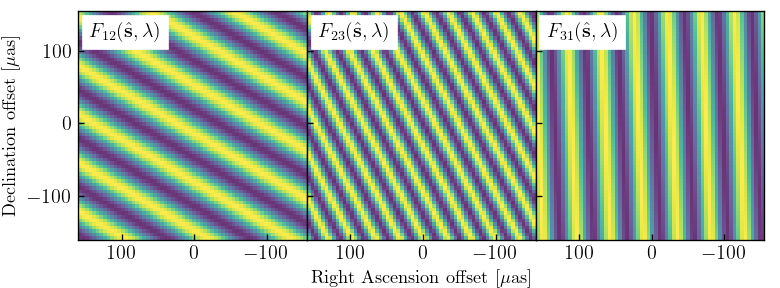

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_cal_fringes.pdf


Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


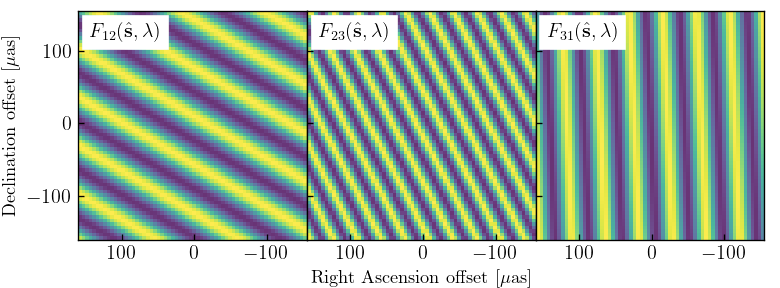

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_crpt_fringes.pdf


Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


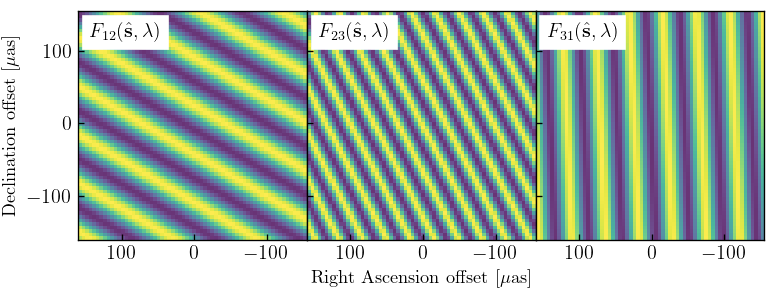

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_uncal_fringes.pdf


Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [19]:
for calkey in ['cal', 'crpt', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        wcs = WCS(imghdrs[fname]).celestial
        data = imgdata[fname].squeeze()
        center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)[0]
        cdelt = wcs.wcs.cdelt
        xvals = (NP.arange(data.shape[1]) - center[0]) * cdelt[0]*3.6e3*1e6 # in uas
        yvals = (NP.arange(data.shape[0]) - center[1]) * cdelt[1]*3.6e3*1e6 # in uas
        xlim = [1.0*xvals[0], 1.0*xvals[-1]] # in uas
        ylim = [1.0*yvals[0], 1.0*yvals[-1]] # in uas
        
        axs[fnamei].pcolorfast(xvals, yvals, data, cmap='viridis', norm=PLTC.Normalize(vmax=data.max(), vmin=data.min()), alpha=0.8)

        axs[fnamei].set_xlim(xlim[0], xlim[1])
        axs[fnamei].set_ylim(ylim[0], ylim[1])

    axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.1, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=15)
    big_ax.set_ylabel('Declination offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=35)

#     PLT.savefig(figdir+'M87_individual_{0}_fringes.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'M87_individual_{0}_fringes.pdf'.format(calkey))

# Plot the three calibrated fringes together for M87 with and without self-calibration and antenna corruption

<IPython.core.display.Javascript object>


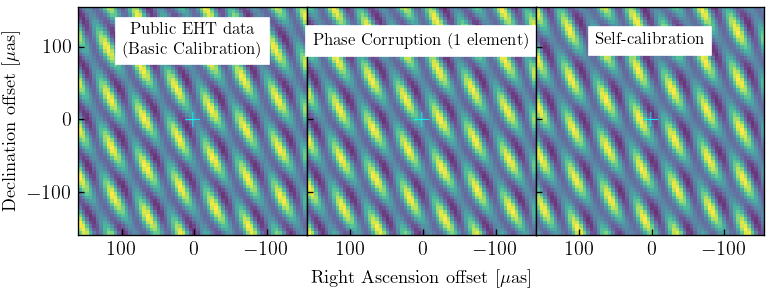

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_all_fringes.pdf


Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [20]:
calstrings = ['uncal', 'crpt', 'cal']
caltexts = ['Public EHT data\n(Basic Calibration)', 'Phase Corruption (1 element)', 'Self-calibration']
fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))

for calind, calkey in enumerate(calstrings):
    fname = imgfilenames['triad-fringes'][calkey]
    wcs = WCS(imghdrs[fname]).celestial
    center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)[0]
    data = imgdata[fname].squeeze()
    cdelt = wcs.wcs.cdelt
    xvals = (NP.arange(data.shape[1]) - center[0]) * cdelt[0]*3.6e3*1e6 # in uas
    yvals = (NP.arange(data.shape[0]) - center[1]) * cdelt[1]*3.6e3*1e6 # in uas
    xlim = [1.0*xvals[0], 1.0*xvals[-1]] # in uas
    ylim = [1.0*yvals[0], 1.0*yvals[-1]] # in uas

    axs[calind].pcolorfast(xvals, yvals, data, cmap='viridis', norm=PLTC.Normalize(vmax=data.max(), vmin=data.min()), alpha=0.8)

    axs[calind].set_xlim(xlim[0], xlim[1])
    axs[calind].set_ylim(ylim[0], ylim[1])

    axs[calind].text(0, 0, '+', transform=axs[calind].transData, ha='center', va='center', fontsize=14, color='cyan')
    axs[calind].text(0.5, 0.85, caltexts[calind], transform=axs[calind].transAxes, ha='center', va='center', fontsize=10, color='black', backgroundcolor='white')

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.18, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=20)
big_ax.set_ylabel('Declination offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=35)

# PLT.savefig(figdir+'M87_all_fringes.pdf', bbox_inches=0)
print(figdir+'M87_all_fringes.pdf')

# Plot the three calibrated/uncalibrated/corrupted two-fringe combinations for M87

<IPython.core.display.Javascript object>


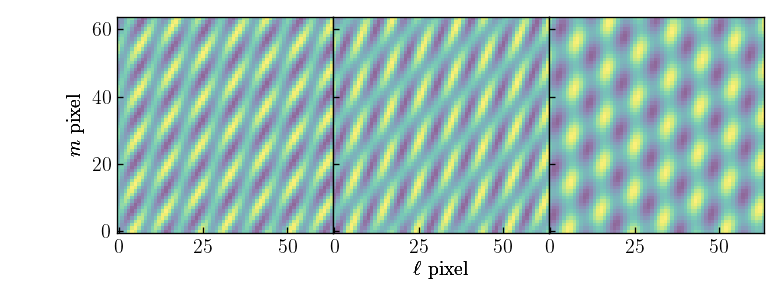

0 AALMsc+AASMsc
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_cal_two-fringes-AALMsc+AASMsc.pdf
1 AASMsc+SMLMsc
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_cal_two-fringes-AASMsc+SMLMsc.pdf
2 SMLMsc+AALMsc
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_cal_two-fringes-SMLMsc+AALMsc.pdf


<IPython.core.display.Javascript object>


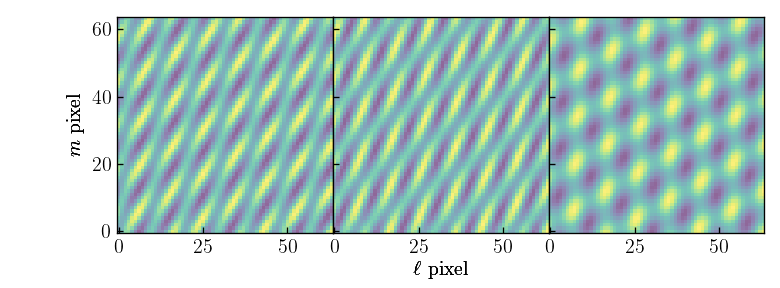

0 AALMx+AASMx
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_crpt_two-fringes-AALMx+AASMx.pdf
1 AASMx+SMLMx
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_crpt_two-fringes-AASMx+SMLMx.pdf
2 SMLMx+AALMx
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_crpt_two-fringes-SMLMx+AALMx.pdf


<IPython.core.display.Javascript object>


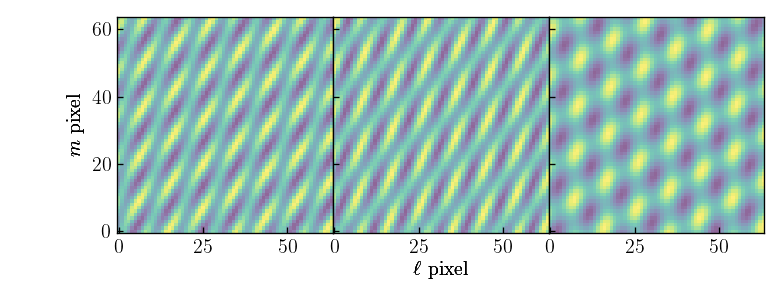

0 AALMr+AASMr
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_uncal_two-fringes-AALMr+AASMr.pdf
1 AASMr+SMLMr
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_uncal_two-fringes-AASMr+SMLMr.pdf
2 SMLMr+AALMr
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_uncal_two-fringes-SMLMr+AALMr.pdf


In [21]:
for calkey in ['cal', 'crpt', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        print(fnamei, fname)
        
        data = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] # Flip the x-axis (second axis in this case)
        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.spines['right'].set_visible(False)
        big_ax.spines['top'].set_visible(False)
        big_ax.spines['left'].set_visible(False)
        big_ax.spines['bottom'].set_visible(False)
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$\ell$ pixel', fontsize=12, weight='medium', labelpad=10)
        big_ax.set_ylabel(r'$m$ pixel', fontsize=12, weight='medium', labelpad=20)

        # PLT.savefig(figdir+'M87_individual_{0}_two-fringes-{1}.pdf'.format(calkey, fname), bbox_inches=0)
        print(figdir+'M87_individual_{0}_two-fringes-{1}.pdf'.format(calkey, fname))

In [22]:
xy_center = {}
xy_std = {}
xy_blc = {}
xy_trc = {}
xy_center['cal'] = {'AALMsc+AASMsc': NP.asarray([34.0, 31.0]), 'SMLMsc+AALMsc': NP.asarray([35.0, 32.0]), 'AASMsc+SMLMsc': NP.asarray([35.0, 33.0])}
xy_std['cal'] = {'AALMsc+AASMsc': NP.asarray([3.0, 1.0]), 'SMLMsc+AALMsc': NP.asarray([2.5, 2.0]), 'AASMsc+SMLMsc': NP.asarray([3.0, 1.0])}
xy_blc['cal'] = {'AALMsc+AASMsc': NP.asarray([29, 24]), 'SMLMsc+AALMsc': NP.asarray([30, 24]), 'AASMsc+SMLMsc': NP.asarray([30, 24])}
xy_trc['cal'] = {'AALMsc+AASMsc': NP.asarray([39, 38]), 'SMLMsc+AALMsc': NP.asarray([40, 38]), 'AASMsc+SMLMsc': NP.asarray([40, 38])}

xy_center['crpt'] = {'AALMx+AASMx': NP.asarray([35.5, 37.0]), 'SMLMx+AALMx': NP.asarray([36.5, 37.5]), 'AASMx+SMLMx': NP.asarray([36.5, 39.0])}
xy_std['crpt'] = {'AALMx+AASMx': NP.asarray([3.0, 1.0]), 'SMLMx+AALMx': NP.asarray([2.5, 2.0]), 'AASMx+SMLMx': NP.asarray([3.0, 1.0])}
xy_blc['crpt'] = {'AALMx+AASMx': NP.asarray([30, 29]), 'SMLMx+AALMx': NP.asarray([32, 32]), 'AASMx+SMLMx': NP.asarray([32, 32])}
xy_trc['crpt'] = {'AALMx+AASMx': NP.asarray([40, 43]), 'SMLMx+AALMx': NP.asarray([41, 43]), 'AASMx+SMLMx': NP.asarray([40, 46])}

xy_center['uncal'] = {'AALMr+AASMr': NP.asarray([35.5, 39.5]), 'SMLMr+AALMr': NP.asarray([36.5, 40.5]), 'AASMr+SMLMr': NP.asarray([36.5, 41.5])}
xy_std['uncal'] = {'AALMr+AASMr': NP.asarray([3.0, 1.0]), 'SMLMr+AALMr': NP.asarray([2.5, 2.0]), 'AASMr+SMLMr': NP.asarray([3.0, 1.0])}
xy_blc['uncal'] = {'AALMr+AASMr': NP.asarray([31, 34]), 'SMLMr+AALMr': NP.asarray([32, 34]), 'AASMr+SMLMr': NP.asarray([33, 36])}
xy_trc['uncal'] = {'AALMr+AASMr': NP.asarray([39, 45]), 'SMLMr+AALMr': NP.asarray([41, 46]), 'AASMr+SMLMr': NP.asarray([40, 48])}

print(xy_blc['cal'])
print(xy_trc['cal'])
print(xy_blc['uncal'])
print(xy_trc['uncal'])

{'AALMsc+AASMsc': array([29, 24]), 'SMLMsc+AALMsc': array([30, 24]), 'AASMsc+SMLMsc': array([30, 24])}
{'AALMsc+AASMsc': array([39, 38]), 'SMLMsc+AALMsc': array([40, 38]), 'AASMsc+SMLMsc': array([40, 38])}
{'AALMr+AASMr': array([31, 34]), 'SMLMr+AALMr': array([32, 34]), 'AASMr+SMLMr': array([33, 36])}
{'AALMr+AASMr': array([39, 45]), 'SMLMr+AALMr': array([41, 46]), 'AASMr+SMLMr': array([40, 48])}


In [23]:
astropy_lmfit_output = {}
astropy_lmfitter = fitting.LevMarLSQFitter()

for calkey in ['cal', 'crpt', 'uncal']:
    astropy_lmfit_output[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        print(fname)
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        g2d_model = models.Gaussian2D(x_mean=xy_center[calkey][fname][0], y_mean=xy_center[calkey][fname][1], x_stddev=xy_std[calkey][fname][0], y_stddev=xy_std[calkey][fname][1], theta=0.0)
        g2p = astropy_lmfitter(g2d_model, xgrid, ygrid, data_subset)
        astropy_lmfit_output[calkey][fname] = {}
        astropy_lmfit_output[calkey][fname]['data'] = NP.copy(data_subset)
        astropy_lmfit_output[calkey][fname]['parameters'] = {'amplitude': g2p.amplitude.value, 'x_center': g2p.x_mean.value, 'y_center': g2p.y_mean.value, 'x_std': g2p.x_stddev.value, 'y_std': g2p.y_stddev.value, 'theta': g2p.theta.value, }
        astropy_lmfit_output[calkey][fname]['modelfit'] = g2p(xgrid, ygrid)
        print(fname+': ', astropy_lmfit_output[calkey][fname]['parameters'])

AALMsc+AASMsc
AALMsc+AASMsc:  {'amplitude': 0.13714389650567907, 'x_center': 33.70378477293138, 'y_center': 30.79314702558116, 'x_std': 5.120320455522569, 'y_std': 0.7761942813169718, 'theta': 1.0308515800847244}
AASMsc+SMLMsc
AASMsc+SMLMsc:  {'amplitude': 0.1561142348249741, 'x_center': 34.644807740441514, 'y_center': 33.007882598640435, 'x_std': 1.1754943508222875e-38, 'y_std': 1.3578370426235304, 'theta': 0.34173334123619825}
SMLMsc+AALMsc
SMLMsc+AALMsc:  {'amplitude': 0.1203697743168959, 'x_center': 34.73899262702795, 'y_center': 31.41550456238755, 'x_std': 1.2624572413056447, 'y_std': 2.703178099783005, 'theta': 6.0086892067735365}
AALMx+AASMx
AALMx+AASMx:  {'amplitude': 0.15220994293703674, 'x_center': 35.31374737355272, 'y_center': 36.60483070332669, 'x_std': 4.977291257645111, 'y_std': 0.7858910966745416, 'theta': 1.0260874925319552}
AASMx+SMLMx
AASMx+SMLMx:  {'amplitude': 0.15726866632166384, 'x_center': 36.57639970332214, 'y_center': 39.01236095722089, 'x_std': 1.175494350822

<IPython.core.display.Javascript object>


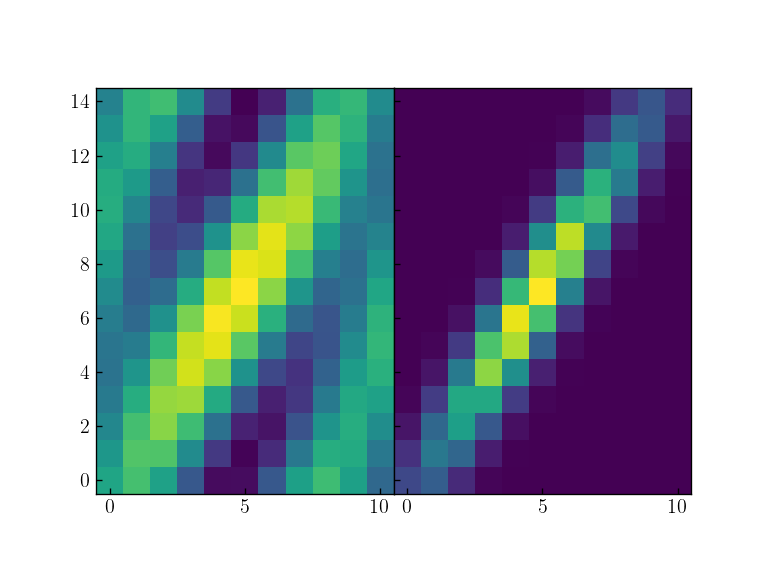

<IPython.core.display.Javascript object>


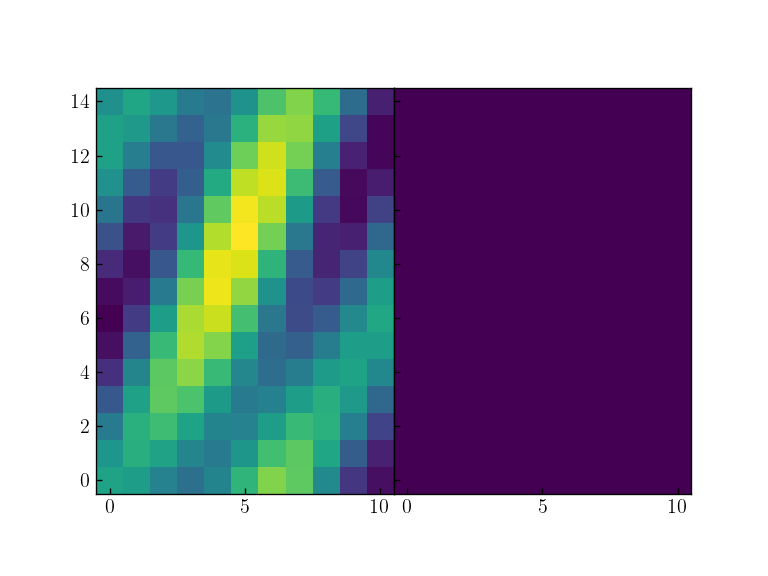

<IPython.core.display.Javascript object>


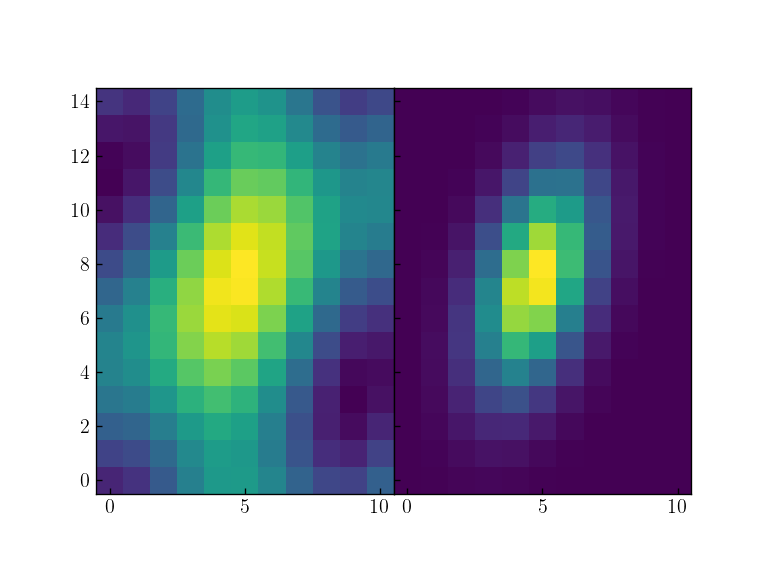

<IPython.core.display.Javascript object>


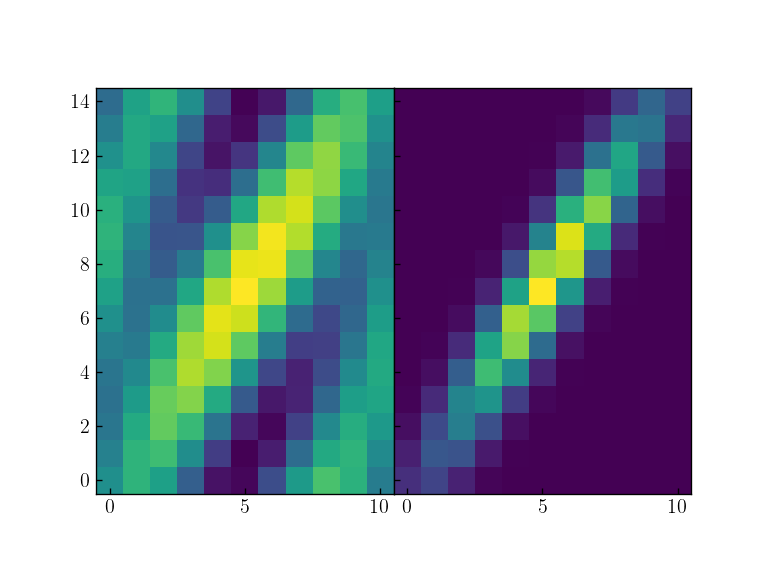

<IPython.core.display.Javascript object>


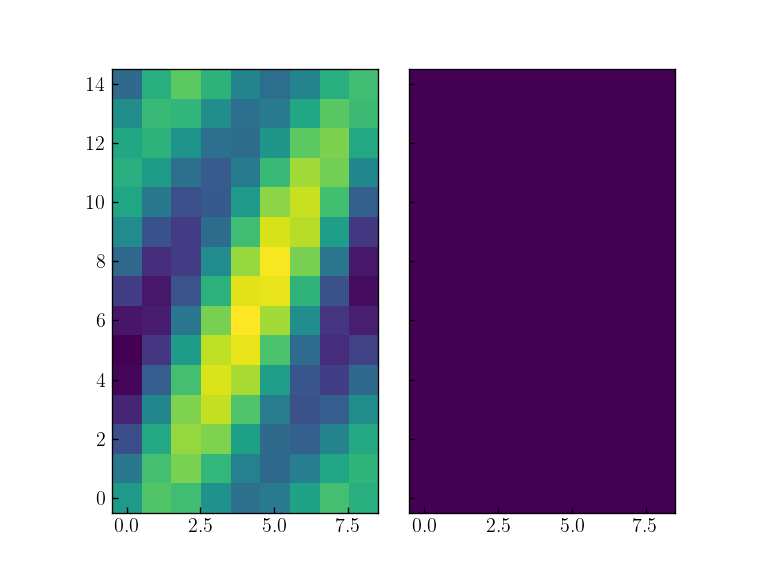

<IPython.core.display.Javascript object>


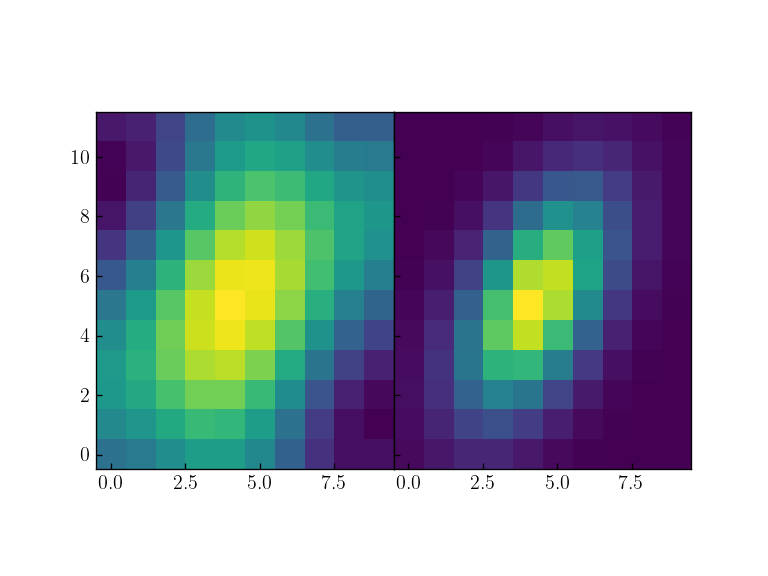

<IPython.core.display.Javascript object>


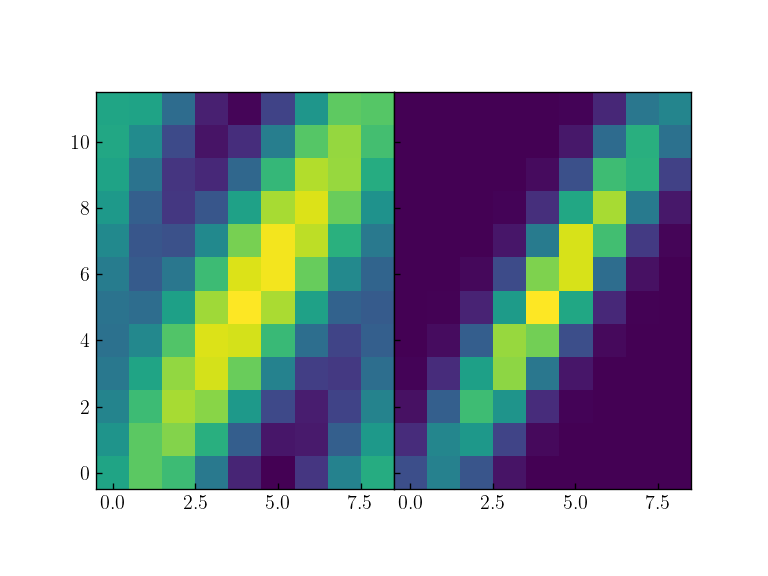

<IPython.core.display.Javascript object>


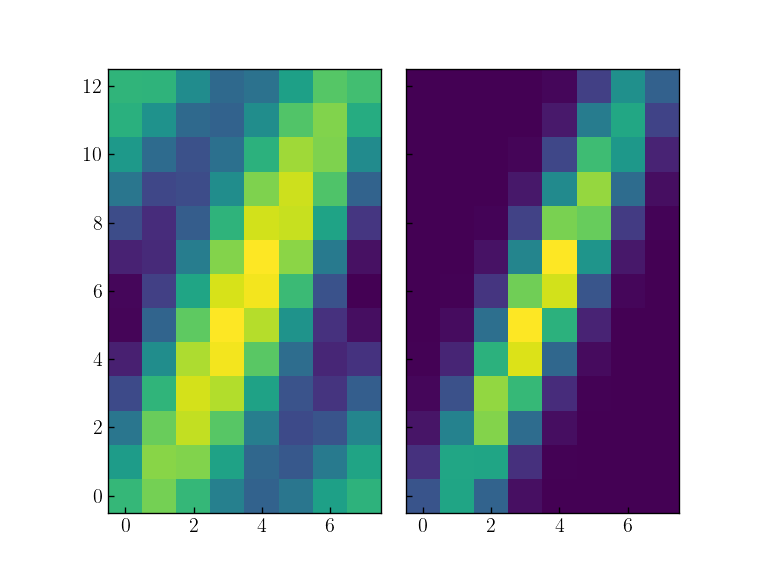

<IPython.core.display.Javascript object>


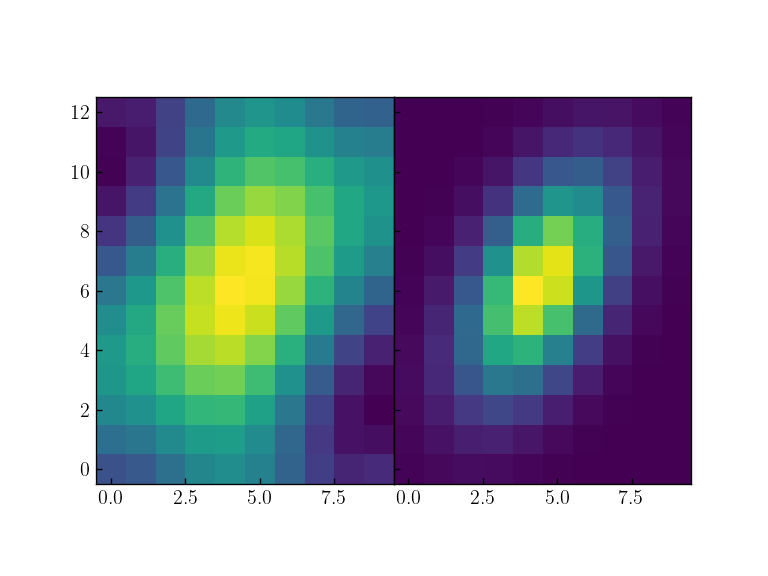

In [24]:
for calkey in ['cal', 'crpt', 'uncal']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(astropy_lmfit_output[calkey][fname]['data'], origin='lower')
        axs[1].imshow(astropy_lmfit_output[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

In [25]:
scipy_fit_output_1 = {}
for calkey in ['cal', 'crpt', 'uncal']:
    scipy_fit_output_1[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        initial_guess = (10.0, xy_center[calkey][fname][0], xy_center[calkey][fname][1], xy_std[calkey][fname][0], xy_std[calkey][fname][1], 0.0)    
        popt, pcov = OPT.curve_fit(gaussian2D_without_offset, (xgrid, ygrid), data_subset.ravel(), p0=initial_guess)
        scipy_fit_output_1[calkey][fname] = {}
        scipy_fit_output_1[calkey][fname]['data'] = NP.copy(data_subset)
        scipy_fit_output_1[calkey][fname]['parameters'] = {'amplitude': popt[0], 'x_center': popt[1], 'y_center': popt[2], 'x_std': popt[3], 'y_std': popt[4], 'theta': popt[5]}
        scipy_fit_output_1[calkey][fname]['covariance'] = NP.copy(pcov)
        scipy_fit_output_1[calkey][fname]['modelfit'] = gaussian2D_without_offset((xgrid, ygrid), scipy_fit_output_1[calkey][fname]['parameters']['amplitude'], scipy_fit_output_1[calkey][fname]['parameters']['x_center'], scipy_fit_output_1[calkey][fname]['parameters']['y_center'], scipy_fit_output_1[calkey][fname]['parameters']['x_std'], scipy_fit_output_1[calkey][fname]['parameters']['y_std'], scipy_fit_output_1[calkey][fname]['parameters']['theta']).reshape(xgrid.shape)
        print('-----{0}-----'.format(fname))
        print('Optimum values:    ', popt)
        print('Diagstd:    ', NP.sqrt(NP.diagonal(pcov)))
        print('Covariance:    ', pcov[1:3,1:3])   

-----AALMsc+AASMsc-----
Optimum values:     [ 0.13715104 33.70378094 30.79314157 -0.77612264  5.12024947  0.53994955]
Diagstd:     [0.01858285 0.37470391 0.61194558 0.10197695 0.8462966  0.0306401 ]
Covariance:     [[0.14040302 0.21760701]
 [0.21760701 0.3744774 ]]
-----AASMsc+SMLMsc-----
Optimum values:     [ 0.14746086 34.81941416 32.95587949 -0.77529213  5.04788037  0.39211653]
Diagstd:     [0.02262426 0.3596307  0.83811195 0.11569341 1.07931852 0.03720041]
Covariance:     [[0.12933424 0.28243932]
 [0.28243932 0.70243164]]
-----SMLMsc+AALMsc-----
Optimum values:     [ 0.12037041 34.73899321 31.41550699  1.26245899  2.70313948 -2.86707806]
Diagstd:     [0.01868373 0.22007959 0.40719648 0.19577351 0.42103146 0.13107305]
Covariance:     [[0.04843503 0.03589856]
 [0.03589856 0.16580897]]
-----AALMx+AASMx-----
Optimum values:     [ 0.15221555 35.31375556 36.60484574 -0.78579444  4.97756032  0.54471663]
Diagstd:     [0.02042859 0.36483617 0.58876106 0.10263799 0.79973779 0.0316026 ]
Covar

<IPython.core.display.Javascript object>


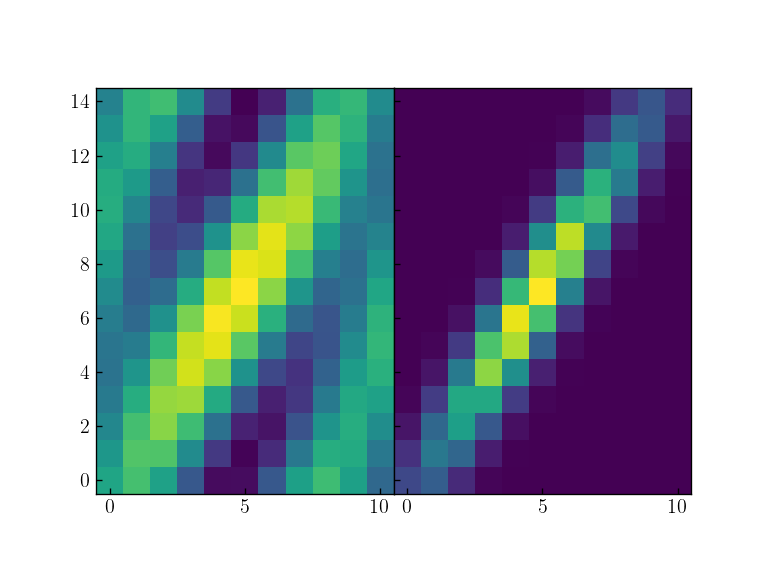

<IPython.core.display.Javascript object>


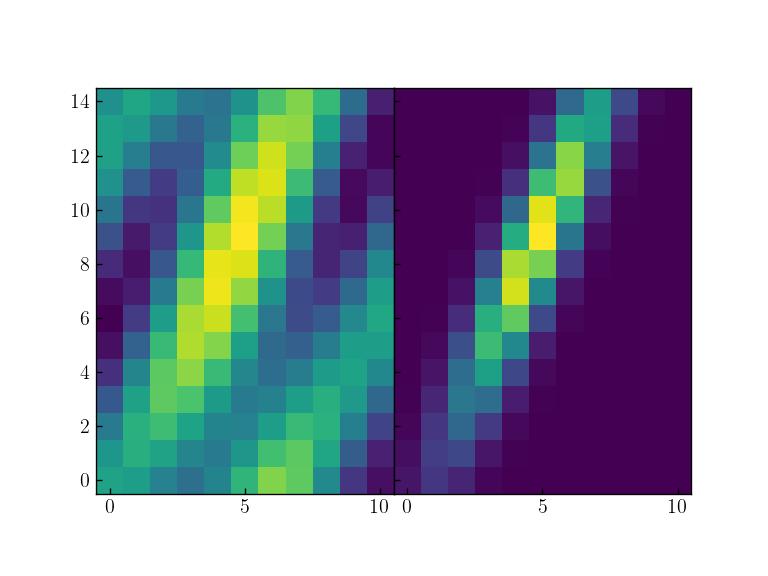

/lustre/aoc/users/nthyagar/src/miniconda2/envs/test-py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


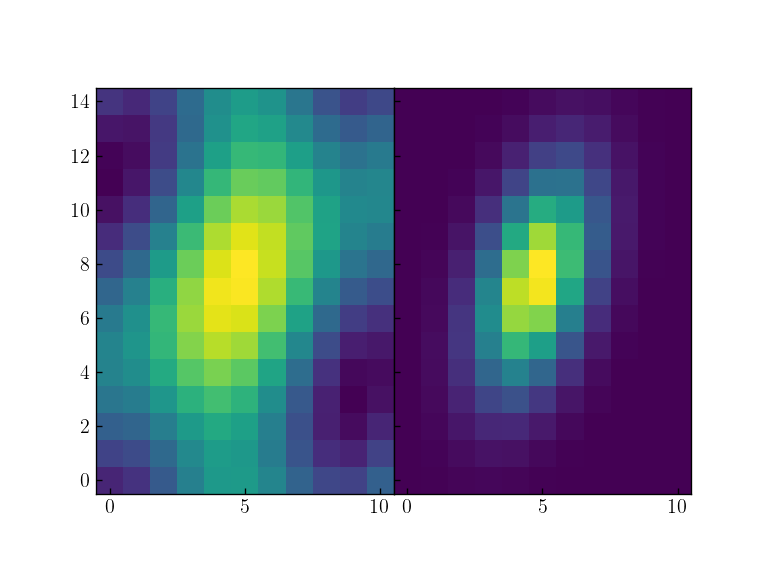

<IPython.core.display.Javascript object>


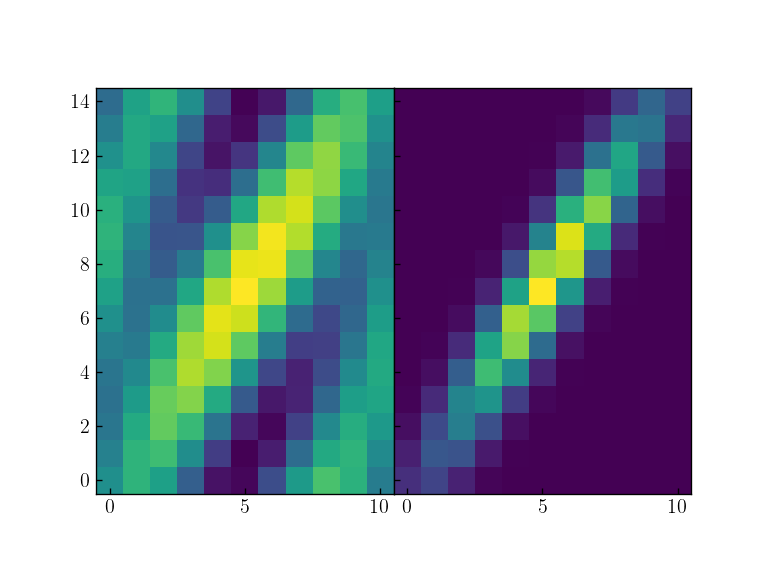

<IPython.core.display.Javascript object>


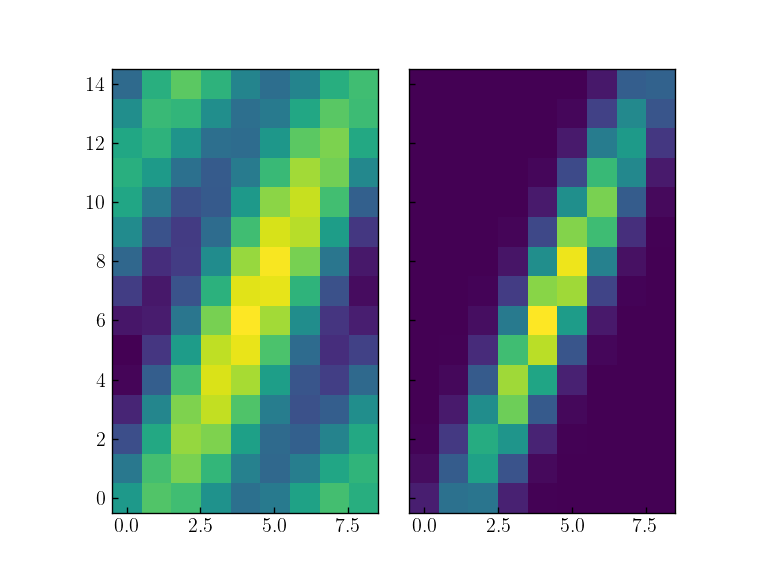

<IPython.core.display.Javascript object>


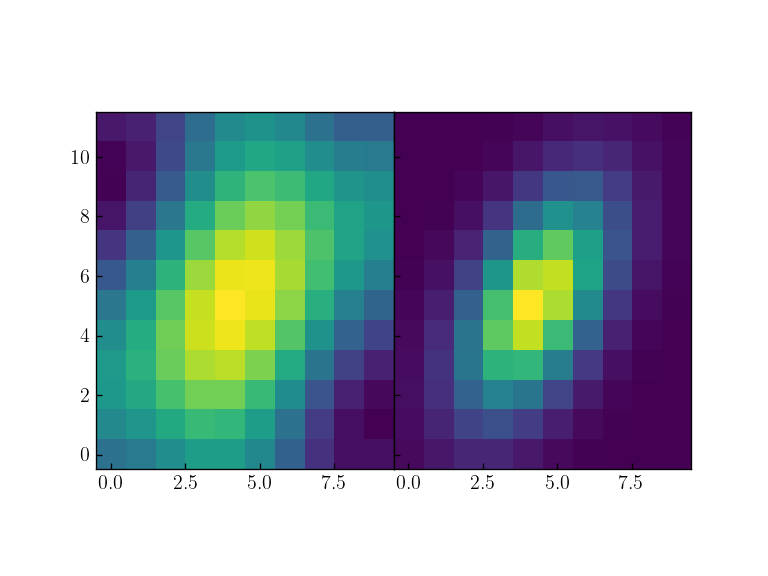

<IPython.core.display.Javascript object>


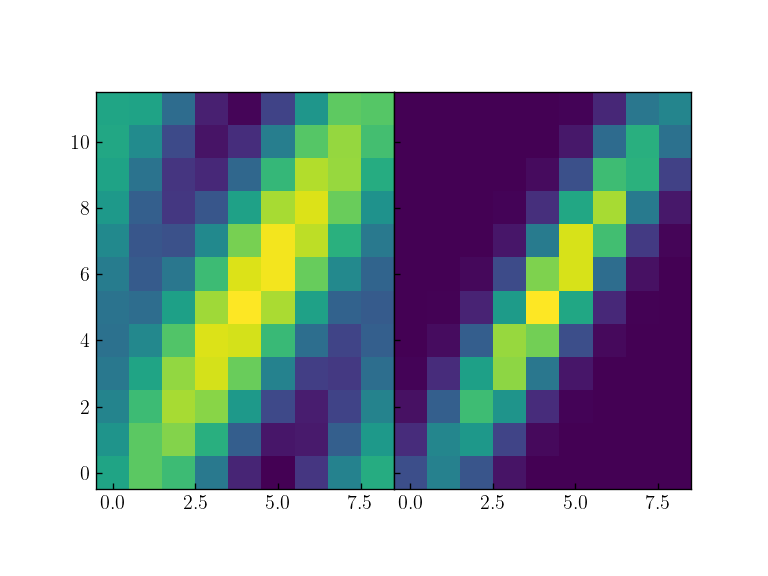

<IPython.core.display.Javascript object>


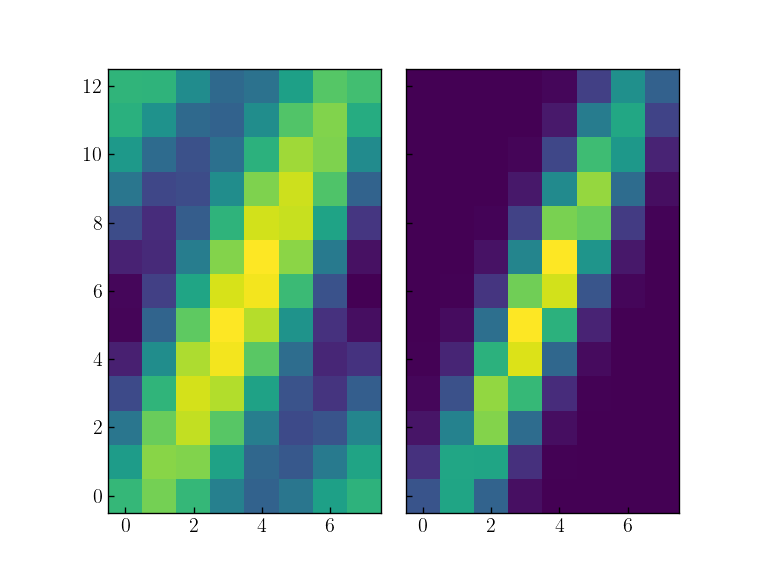

<IPython.core.display.Javascript object>


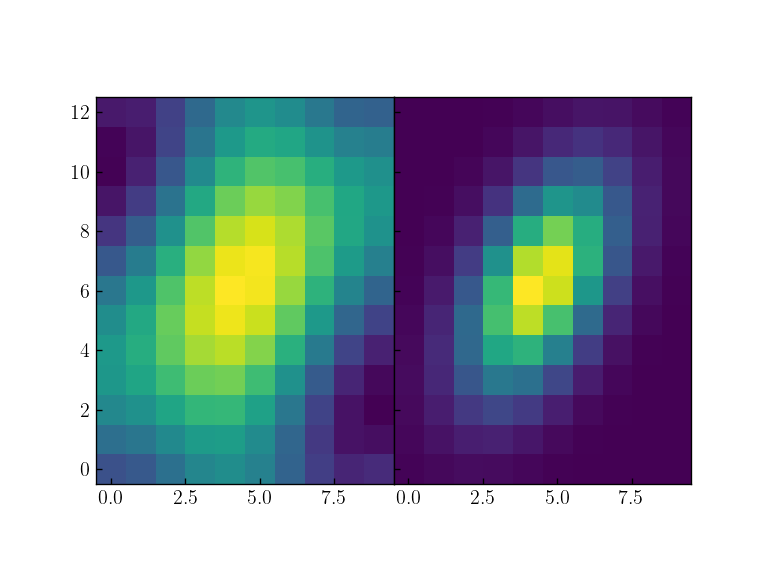

In [26]:
for calkey in ['cal', 'crpt', 'uncal']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(scipy_fit_output_1[calkey][fname]['data'], origin='lower')
        axs[1].imshow(scipy_fit_output_1[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

In [27]:
scipy_fit_output_2 = {}
for calkey in ['cal', 'crpt', 'uncal']:
    scipy_fit_output_2[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        initial_guess = (10.0, xy_center[calkey][fname][0], xy_center[calkey][fname][1], xy_std[calkey][fname][0], xy_std[calkey][fname][1], 0.0, 0.0)    
        popt, pcov = OPT.curve_fit(gaussian2D_with_offset, (xgrid, ygrid), data_subset.ravel(), p0=initial_guess)
        scipy_fit_output_2[calkey][fname] = {}
        scipy_fit_output_2[calkey][fname]['data'] = NP.copy(data_subset)
        scipy_fit_output_2[calkey][fname]['parameters'] = {'amplitude': popt[0], 'x_center': popt[1], 'y_center': popt[2], 'x_std': popt[3], 'y_std': popt[4], 'theta': popt[5], 'offset': popt[6]}
        scipy_fit_output_2[calkey][fname]['covariance'] = NP.copy(pcov)
        scipy_fit_output_2[calkey][fname]['modelfit'] = gaussian2D_with_offset((xgrid, ygrid), scipy_fit_output_2[calkey][fname]['parameters']['amplitude'], scipy_fit_output_2[calkey][fname]['parameters']['x_center'], scipy_fit_output_2[calkey][fname]['parameters']['y_center'], scipy_fit_output_2[calkey][fname]['parameters']['x_std'], scipy_fit_output_2[calkey][fname]['parameters']['y_std'], scipy_fit_output_2[calkey][fname]['parameters']['theta'], scipy_fit_output_2[calkey][fname]['parameters']['offset']).reshape(xgrid.shape)
        print('-----{0}-----'.format(fname))
        print('    Optimum values:    ', popt)
        print('    Diagstd:    ', NP.sqrt(NP.diagonal(pcov)))
        print('    Covariance:    ', pcov[1:3,1:3])

-----AALMsc+AASMsc-----
    Optimum values:     [ 1.67081869e-01  3.37071153e+01  3.07994368e+01  9.67707685e-01
  6.20650917e+00  5.48663149e-01 -3.27913168e-02]
    Diagstd:     [0.01313783 0.27550912 0.44322144 0.08116813 0.73006796 0.01927873
 0.0040048 ]
    Covariance:     [[0.07590527 0.11648253]
 [0.11648253 0.19644524]]
-----AASMsc+SMLMsc-----
    Optimum values:     [ 0.18312411 34.79370349 32.90213595 -0.99684088  6.59545206  0.38494383
 -0.04142497]
    Diagstd:     [0.01478702 0.28025657 0.67864555 0.08684814 1.01141312 0.02103843
 0.00462102]
    Covariance:     [[0.07854375 0.18165717]
 [0.18165717 0.46055978]]
-----SMLMsc+AALMsc-----
    Optimum values:     [ 0.18167462 34.78473028 31.38465951  2.45077603  5.22922422 -2.84188594
 -0.08383139]
    Diagstd:     [0.00543883 0.0632366  0.12209147 0.11113381 0.22446559 0.0215749
 0.00521986]
    Covariance:     [[0.00399887 0.00361196]
 [0.00361196 0.01490633]]
-----AALMx+AASMx-----
    Optimum values:     [ 1.85067958e-01  

<IPython.core.display.Javascript object>


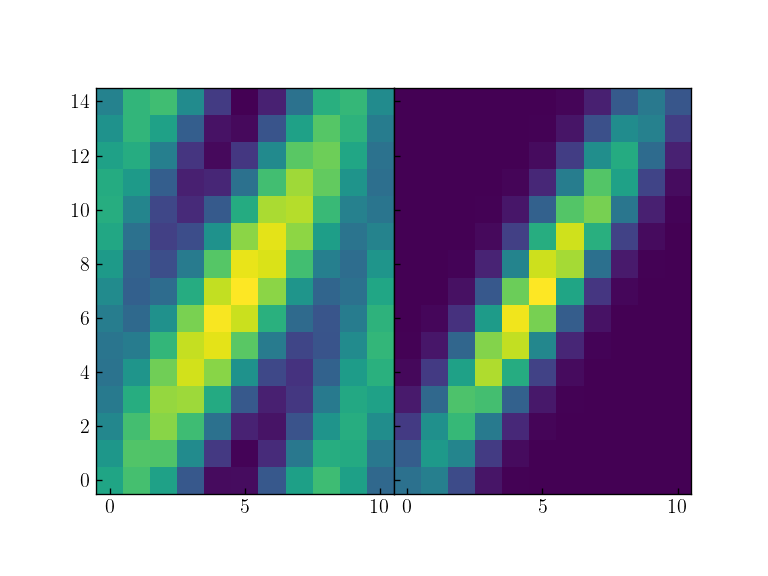

<IPython.core.display.Javascript object>


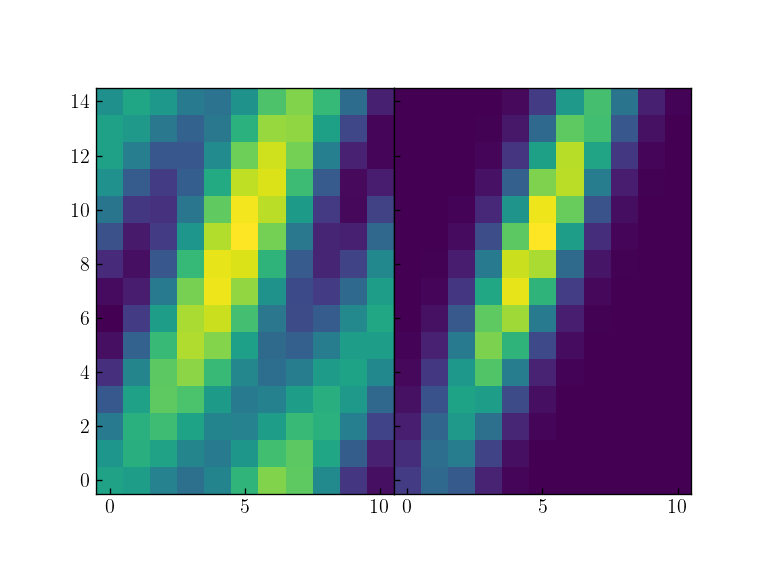

<IPython.core.display.Javascript object>


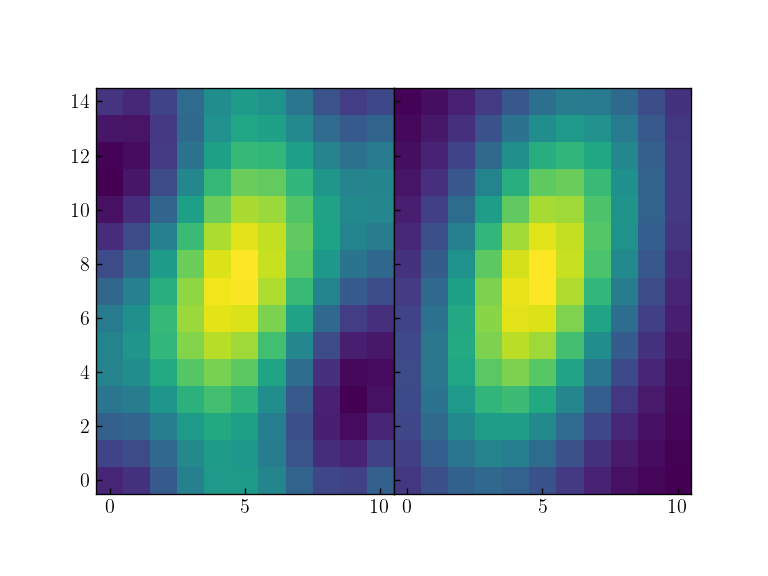

<IPython.core.display.Javascript object>


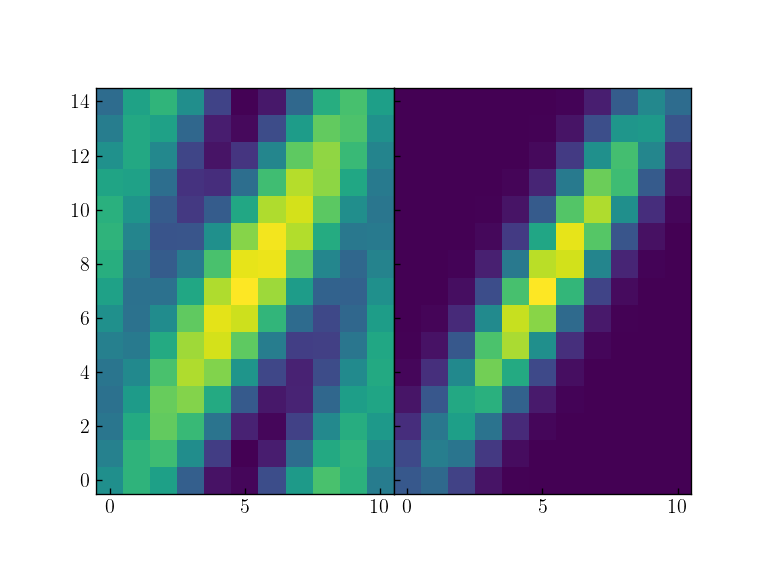

<IPython.core.display.Javascript object>


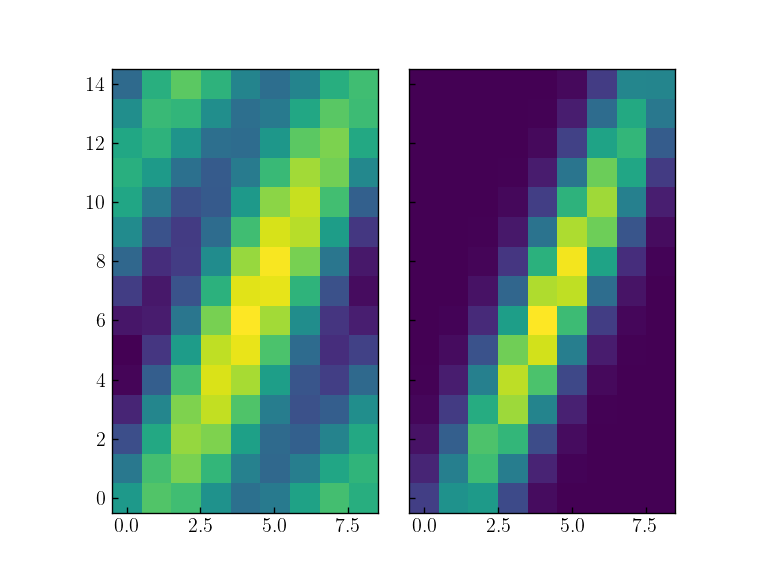

<IPython.core.display.Javascript object>


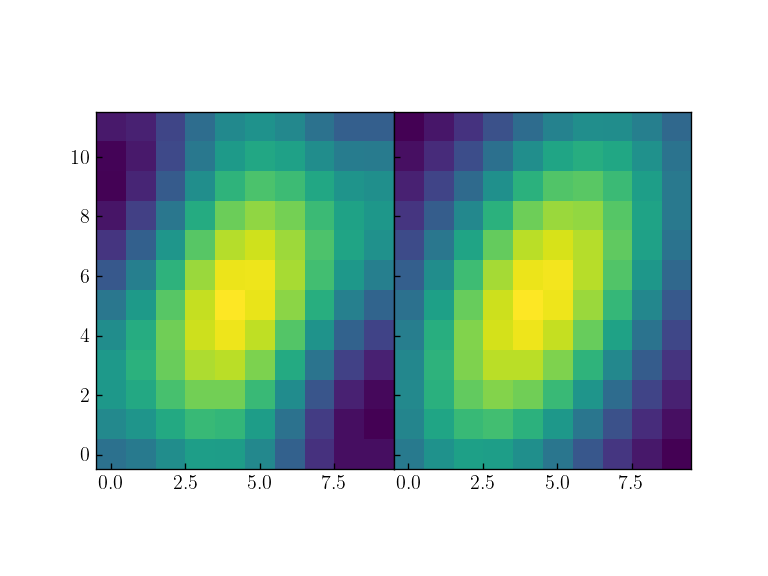

<IPython.core.display.Javascript object>


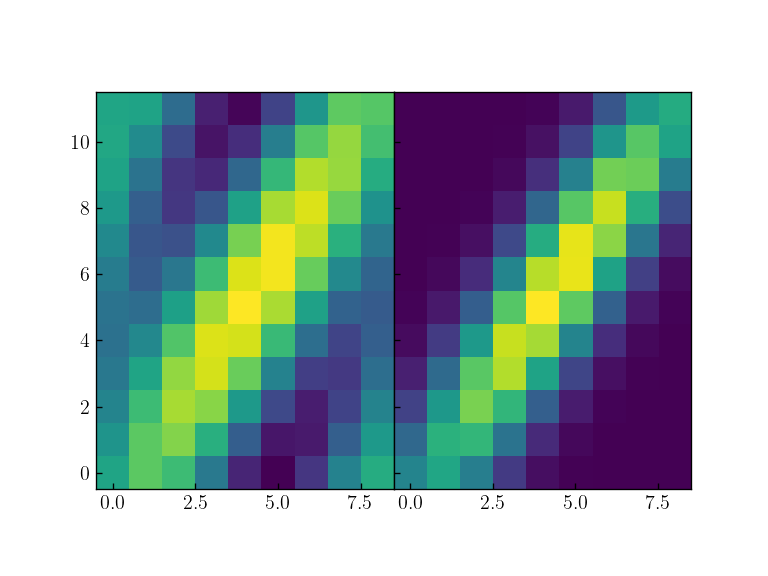

<IPython.core.display.Javascript object>


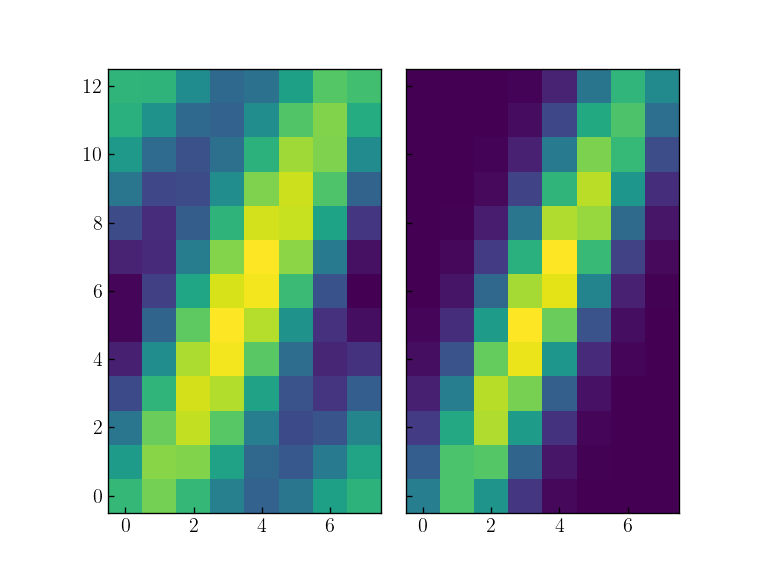

<IPython.core.display.Javascript object>


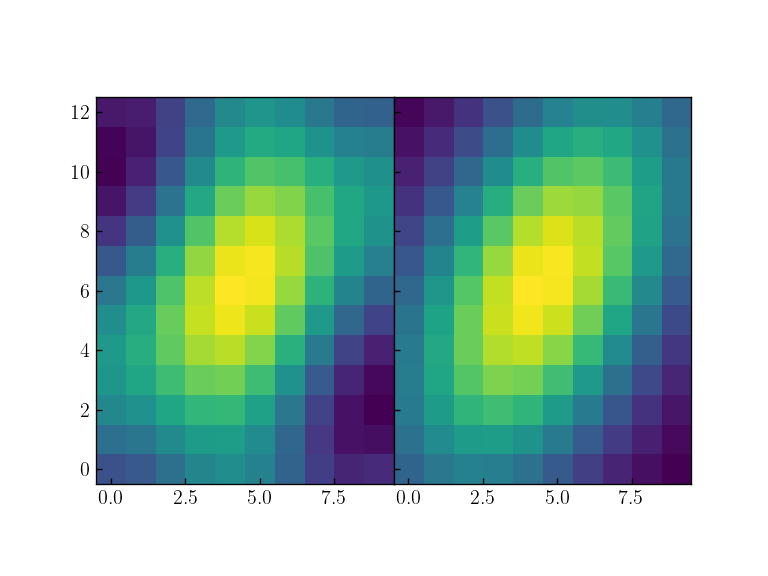

In [28]:
for calkey in ['cal', 'crpt', 'uncal']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(scipy_fit_output_2[calkey][fname]['data'], origin='lower')
        axs[1].imshow(scipy_fit_output_2[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

# Determine fringe NPC equations

In [29]:
points = {}
coeff_dvect_lines = {}
dvect_range_lines = {}
two_fringes_names = {}

dl_data = NP.sin(NP.radians(NP.abs(wcs.wcs.cdelt[0])))
dm_data = NP.sin(NP.radians(NP.abs(wcs.wcs.cdelt[1])))

fringe_NPC_info = {}
for calkey in ['cal', 'crpt', 'uncal']:
    points[calkey] = []
    coeff_dvect_lines[calkey] = []
    two_fringes_names[calkey] = []
    antpair_1_inds = []
    for dbl_antpair,dblfname in double_antpairs_fringenames[calkey]:
        points[calkey] += [NP.asarray([scipy_fit_output_2[calkey][dblfname]['parameters']['x_center'], scipy_fit_output_2[calkey][dblfname]['parameters']['y_center']])]
        antpair_1_inds += [antpairs.index(dbl_antpair[0])]
        print(dbl_antpair,dblfname)
    points[calkey] = NP.asarray(points[calkey])
    antpair_1_inds = NP.asarray(antpair_1_inds)
    coeff_dvect_lines[calkey] = GEOM.generate_line_from_point_and_slope(points[calkey], fringe_slopes_data[antpair_1_inds])
#     set_trace()
    dvect_range_lines[calkey] = GEOM.generate_parallel_lines_at_distance_from_line(coeff_dvect_lines[calkey][:,:2], coeff_dvect_lines[calkey][:,2], NP.degrees(pos_err[antpair_1_inds])/NP.sqrt(NP.abs(wcs.wcs.cdelt[0]*wcs.wcs.cdelt[1])))
    
    fringe_NPC_info[calkey] = {}
    for dbl_antpair,dblfname in double_antpairs_fringenames[calkey]:
        antpair1 = dbl_antpair[0]
        antpair1_ind = antpairs.index(antpair1)
        fnamei = antpair1_ind
        fname = imgfilenames['bl-fringes'][calkey][fnamei]
        fringe_NPC_info[calkey][fname] = {}
        fringe_NPC_info[calkey][fname]['equation'] = coeff_dvect_lines[calkey][fnamei]
        xvals = NP.arange(imgdata[imgfilenames['bl-fringes'][calkey][fnamei]].squeeze().shape[1])
        yvals = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], coeff_dvect_lines[calkey][fnamei][2], xvals)
        yvals_lim1 = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], dvect_range_lines[calkey][fnamei][0], xvals)
        yvals_lim2 = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], dvect_range_lines[calkey][fnamei][1], xvals)
        fringe_NPC_info[calkey][fname]['xvals'] = NP.copy(xvals)
        fringe_NPC_info[calkey][fname]['yvals'] = NP.copy(yvals)
        fringe_NPC_info[calkey][fname]['yvals_lim1'] = NP.copy(yvals_lim1)
        fringe_NPC_info[calkey][fname]['yvals_lim2'] = NP.copy(yvals_lim2)          

((1, 5), (5, 7)) AALMsc+AASMsc
((5, 7), (7, 1)) AASMsc+SMLMsc
((7, 1), (1, 5)) SMLMsc+AALMsc
((1, 5), (5, 7)) AALMx+AASMx
((5, 7), (7, 1)) AASMx+SMLMx
((7, 1), (1, 5)) SMLMx+AALMx
((1, 5), (5, 7)) AALMr+AASMr
((5, 7), (7, 1)) AASMr+SMLMr
((7, 1), (1, 5)) SMLMr+AALMr


In [30]:
print(type(imgdata['two-fringes'][calkey]))
print(imgfilenames['bl-fringes'][calkey])
print(two_fringes_names[calkey])
print(points[calkey].shape)
print(fringe_slopes_data.shape)

<class 'dict'>
['AALMr.fits', 'AASMr.fits', 'SMLMr.fits']
[]
(3, 2)
(3,)


In [31]:
print(coeff_dvect_lines)
print(fringe_slopes_data)
print(yvals)
print(yvals_lim1)
print(yvals_lim2)

{'cal': array([[-5.83819537e-01,  1.00000000e+00,  1.11205643e+01],
       [-1.90710255e+00,  1.00000000e+00, -3.34530248e+01],
       [-2.31386661e+01,  1.00000000e+00, -7.73487600e+02]]), 'crpt': array([[-5.83819537e-01,  1.00000000e+00,  1.59698722e+01],
       [-1.90710255e+00,  1.00000000e+00, -3.07444309e+01],
       [-2.31386661e+01,  1.00000000e+00, -8.03031653e+02]]), 'uncal': array([[-5.83819537e-01,  1.00000000e+00,  1.89916299e+01],
       [-1.90710255e+00,  1.00000000e+00, -2.79019742e+01],
       [-2.31386661e+01,  1.00000000e+00, -8.03014103e+02]])}
[ 0.58381954  1.90710255 23.1386661 ]
[-803.01410253 -779.87543644 -756.73677034 -733.59810425 -710.45943815
 -687.32077205 -664.18210596 -641.04343986 -617.90477377 -594.76610767
 -571.62744157 -548.48877548 -525.35010938 -502.21144328 -479.07277719
 -455.93411109 -432.795445   -409.6567789  -386.5181128  -363.37944671
 -340.24078061 -317.10211452 -293.96344842 -270.82478232 -247.68611623
 -224.54745013 -201.40878403 -178.27

# Verify that the fringe NPC equations determined align with the fringes in direction-cosine coordinates

Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


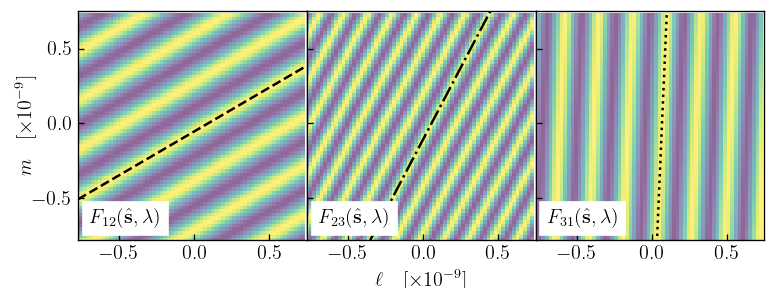

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_cal_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


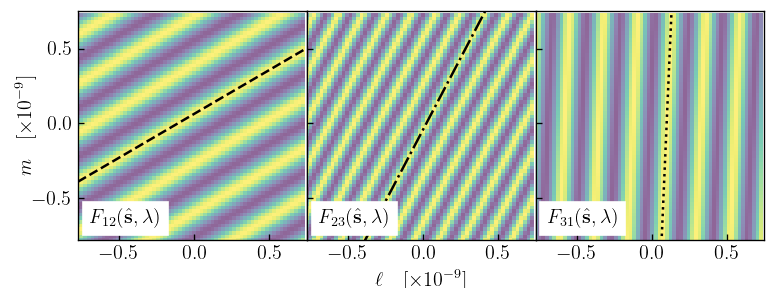

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_crpt_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


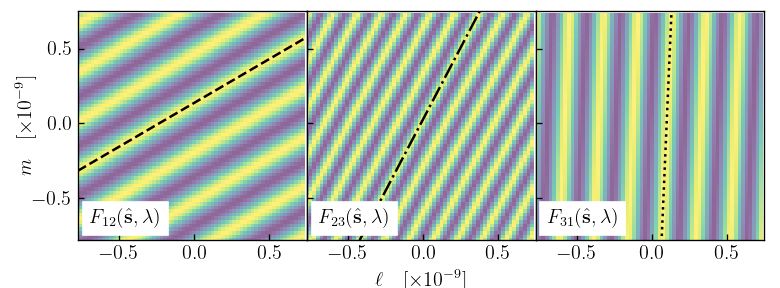

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_uncal_fringes_fitted_NPC_dircos.pdf


In [32]:
fname_init = 'AALMsc.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
lvect_data = (NP.arange(imghdrs[fname_init]['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
mvect_data = (NP.arange(imghdrs[fname_init]['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

ls = ['--', '-.', ':']
for calkey in ['cal', 'crpt', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        data = imgdata[fname].squeeze()[:,::-1]
        axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-9, (mvect_data-0.5*dm_data)/1e-9, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

        l_xvals = (fringe_NPC_info[calkey][fname]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fname]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[fnamei].plot(l_xvals/1e-9, m_yvals/1e-9, color='black', ls=ls[fnamei])
        axs[fnamei].set_xlim(lvect_data.min()/1e-9, lvect_data.max()/1e-9)
        axs[fnamei].set_ylim(mvect_data.min()/1e-9, mvect_data.max()/1e-9)

    axs[0].text(0.05, 0.05, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.05, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.05, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.1, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\ell \quad [\times 10^{-9}]$', fontsize=12, weight='medium', labelpad=15)
    big_ax.set_ylabel(r'$m \quad [\times 10^{-9}]$', fontsize=12, weight='medium', labelpad=25)

#     PLT.savefig(figdir+'M87_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'M87_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey))

# Verify that the fringe NPC equations determined align with the fringes in RA-Dec coordinates

<IPython.core.display.Javascript object>


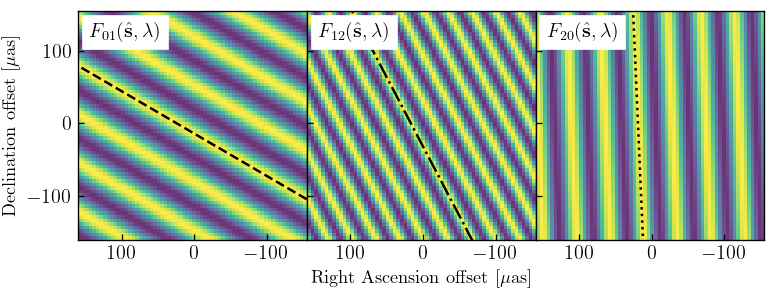

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_cal_fringes_fitted.pdf


Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


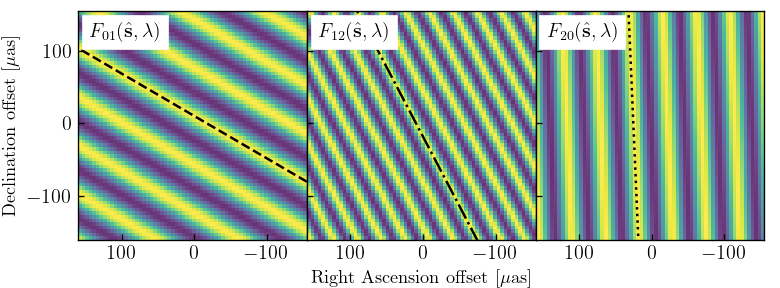

Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_crpt_fringes_fitted.pdf


<IPython.core.display.Javascript object>


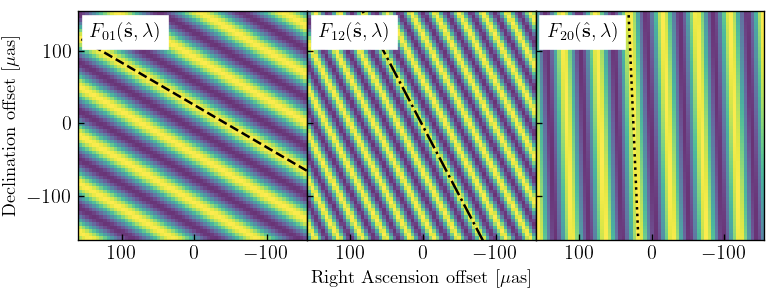

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_individual_uncal_fringes_fitted.pdf


Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [33]:
for calkey in ['cal', 'crpt', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        wcs = WCS(imghdrs[fname]).celestial
        data = imgdata[fname].squeeze()
        center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)[0]
        cdelt = wcs.wcs.cdelt
        xvals = (NP.arange(data.shape[1]) - center[0]) * cdelt[0]*3.6e3*1e6 # in uas
        yvals = (NP.arange(data.shape[0]) - center[1]) * cdelt[1]*3.6e3*1e6 # in uas
        xlim = [1.0*xvals[0], 1.0*xvals[-1]] # in uas
        ylim = [1.0*yvals[0], 1.0*yvals[-1]] # in uas
        
        axs[fnamei].pcolorfast(xvals, yvals, data, cmap='viridis', norm=PLTC.Normalize(vmax=data.max(), vmin=data.min()), alpha=0.8)
        
        npc_xvals = (fringe_NPC_info[calkey][fname]['xvals'] - center[0]+1) * NP.abs(cdelt[0])*3.6e3*1e6 # in uas
        npc_yvals = (fringe_NPC_info[calkey][fname]['yvals'] - center[1]) * NP.abs(cdelt[1])*3.6e3*1e6 # in uas
        axs[fnamei].plot(npc_xvals, npc_yvals, color='black', ls=ls[fnamei])        

        axs[fnamei].set_xlim(xlim[0], xlim[1])
        axs[fnamei].set_ylim(ylim[0], ylim[1])

    axs[0].text(0.05, 0.95, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.95, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.1, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=15)
    big_ax.set_ylabel('Declination offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=35)

#     PLT.savefig(figdir+'M87_individual_{0}_fringes_fitted.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'M87_individual_{0}_fringes_fitted.pdf'.format(calkey))

# Plot three fringe images calibrated and uncalibrated with fitted NPC in direction-cosine coordinates

Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


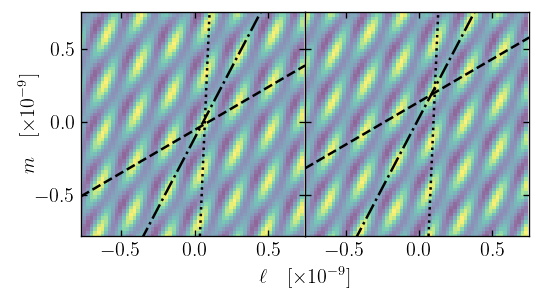

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_all_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


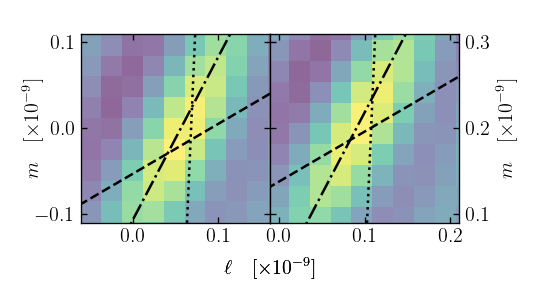

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_all_fringes_fitted_NPC_zoomed_dircos.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_all_fringes_fitted_NPC_zoomed_dircos.pdf


In [34]:
fname_init = 'AALMsc.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
lvect_data = (NP.arange(imghdrs[fname_init]['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
mvect_data = (NP.arange(imghdrs[fname_init]['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()[:,::-1]
    axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-9, (mvect_data-0.5*dm_data)/1e-9, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[calind].plot(l_xvals/1e-9, m_yvals/1e-9, color='black', ls=ls[fnamej])
    axs[calind].set_xlim(lvect_data.min()/1e-9, lvect_data.max()/1e-9)
    axs[calind].set_ylim(mvect_data.min()/1e-9, mvect_data.max()/1e-9)
    axs[calind].tick_params(bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.15, right=0.98, bottom=0.16, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel(r'$\ell \quad [\times 10^{-9}]$', fontsize=12, weight='medium', labelpad=15)
big_ax.set_ylabel(r'$m \quad [\times 10^{-9}]$', fontsize=12, weight='medium', labelpad=25)

PLT.savefig(figdir+'M87_all_fringes_fitted_NPC_dircos.pdf', bbox_inches=0)
print(figdir+'M87_all_fringes_fitted_NPC_dircos.pdf')

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()[:,::-1]
    axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-9, (mvect_data-0.5*dm_data)/1e-9, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[calind].plot(l_xvals/1e-9, m_yvals/1e-9, color='black', ls=ls[fnamej])
    if calkey == 'cal': 
        axs[calind].set_xlim(-0.06, 0.16)
        axs[calind].set_ylim(-0.11, 0.11)
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].set_ylabel(r'$m \quad [\times 10^{-9}]$', fontsize=12, weight='medium', labelpad=-5)
    else:
        axs[calind].set_xlim(-0.01, 0.21)
        axs[calind].set_ylim(0.09, 0.31)
        axs[calind].yaxis.tick_right()
        axs[calind].yaxis.set_label_position('right')
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)
        axs[calind].set_ylabel(r'$m \quad [\times 10^{-9}]$', fontsize=12, weight='medium')
        
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.16, top=0.95)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\ell \quad [\times 10^{-9}]$', fontsize=12, weight='medium', labelpad=10)

#     PLT.savefig(figdir+'M87_all_fringes_fitted_NPC_zoomed_dircos.pdf', bbox_inches=0)
    print(figdir+'M87_all_fringes_fitted_NPC_zoomed_dircos.pdf')

# Plot three fringe images calibrated and uncalibrated with fitted NPC in RA-Dec coordinates

Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


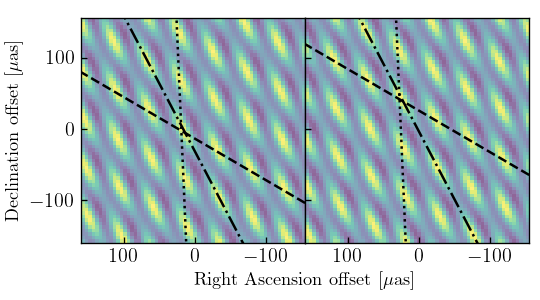

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_all_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


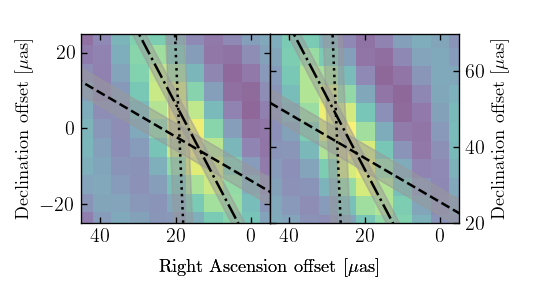

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_all_fringes_fitted_NPC_zoomed.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_all_fringes_fitted_NPC_zoomed.pdf


In [35]:
nsigma = 1

fname_init = 'AALMsc.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
raoffset_data = (NP.arange(imghdrs[fname_init]['NAXIS1']) - center[0,0]) * cdelt[0]*3.6e3*1e6 # in uas
decoffset_data = (NP.arange(imghdrs[fname_init]['NAXIS2']) - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.5))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
#     axs[calind].pcolorfast(raoffset_data, decoffset_data, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    axs[calind].pcolorfast(raoffset_data, decoffset_data, data.real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        npc_ravals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * cdelt[0]*3.6e3*1e6 # in uas
        npc_decvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
        axs[calind].plot(npc_ravals[::-1], npc_decvals, color='black', ls=ls[fnamej])
        axs[calind].set_xlim(raoffset_data[0], raoffset_data[-1])
        axs[calind].set_ylim(decoffset_data[0], decoffset_data[-1])
#     for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
#         xvals = fringe_NPC_info[calkey][fn]['xvals']
#         yvals = fringe_NPC_info[calkey][fn]['yvals']
#         yvals_lim1_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim1']
#         yvals_lim2_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim2']
#         yvals_lim1_nsigma = yvals + nsigma * (yvals_lim1_1sigma - yvals)
#         yvals_lim2_nsigma = yvals + nsigma * (yvals_lim2_1sigma - yvals)
#         npc_ravals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * cdelt[0]*3.6e3*1e6 # in uas
#         npc_decvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
#         npc_decvals_lim1_nsigma = (yvals_lim1_nsigma - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
#         npc_decvals_lim2_nsigma = (yvals_lim2_nsigma - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
#         axs[calind].fill_between(npc_ravals[::-1], npc_decvals_lim1_nsigma, npc_decvals_lim2_nsigma, color='0.6', alpha=0.5)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=10)
big_ax.set_ylabel('Declination offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=35)

# PLT.savefig(figdir+'M87_all_fringes_fitted_NPC.pdf', bbox_inches=0)
print(figdir+'M87_all_fringes_fitted_NPC.pdf')

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].pcolorfast(raoffset_data, decoffset_data, data.real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        npc_ravals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * cdelt[0]*3.6e3*1e6 # in uas
        npc_decvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
        axs[calind].plot(npc_ravals[::-1], npc_decvals, color='black', ls=ls[fnamej])
        axs[calind].set_xlim(raoffset_data[0], raoffset_data[-1])
        axs[calind].set_ylim(decoffset_data[0], decoffset_data[-1])
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        yvals_lim1_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim1']
        yvals_lim2_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim2']
        yvals_lim1_nsigma = yvals + nsigma * (yvals_lim1_1sigma - yvals)
        yvals_lim2_nsigma = yvals + nsigma * (yvals_lim2_1sigma - yvals)
        npc_ravals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * cdelt[0]*3.6e3*1e6 # in uas
        npc_decvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
        npc_decvals_lim1_nsigma = (yvals_lim1_nsigma - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
        npc_decvals_lim2_nsigma = (yvals_lim2_nsigma - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
        axs[calind].fill_between(npc_ravals[::-1], npc_decvals_lim1_nsigma, npc_decvals_lim2_nsigma, color='0.6', alpha=0.5)
    if calkey == 'cal': 
        axs[calind].set_xlim(45, -5)
        axs[calind].set_ylim(-25, 25)
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].set_ylabel('Declination offset\t'+r'[$\mu$as]', fontsize=11, weight='medium')
    else:
        axs[calind].set_xlim(45, -5)
        axs[calind].set_ylim(20, 70)
        axs[calind].yaxis.tick_right()
        axs[calind].yaxis.set_label_position('right')
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)
        axs[calind].set_ylabel('Declination offset\t'+r'[$\mu$as]', fontsize=11, weight='medium')
        
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.16, top=0.95)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=10)

#     PLT.savefig(figdir+'M87_all_fringes_fitted_NPC_zoomed.pdf', bbox_inches=0)
    print(figdir+'M87_all_fringes_fitted_NPC_zoomed.pdf')

## Plot the three calibrated fringes together for M87 with and without self-calibration and antenna corruption

Set OBSGEO-B to    -0.000000 from OBSGEO-[XYZ].
Set OBSGEO-H to -6378140.000 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


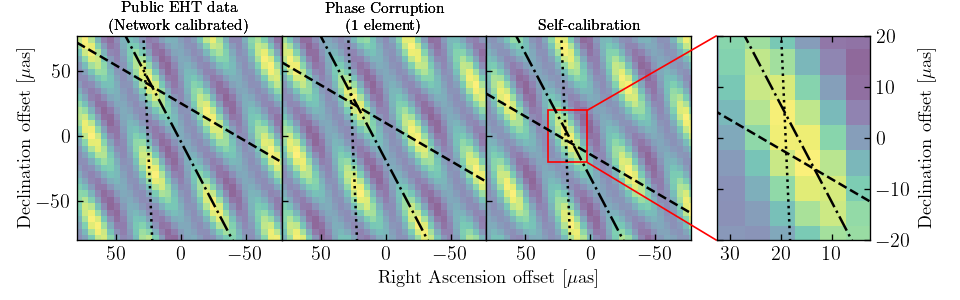

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/M87_all_fringes_fitted_NPC_multipanel.pdf


In [41]:
fname_init = 'AALMsc.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
raoffset_data = (NP.arange(imghdrs[fname_init]['NAXIS1']) - center[0,0]) * cdelt[0]*3.6e3*1e6 # in uas
decoffset_data = (NP.arange(imghdrs[fname_init]['NAXIS2']) - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
calstrings = ['uncal', 'crpt', 'cal']
caltexts = ['Public EHT data\n(Network calibrated)', 'Phase Corruption\n(1 element)', 'Self-calibration']

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(8.0,2.5))
for calind,calkey in enumerate(['uncal', 'crpt', 'cal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].pcolorfast(raoffset_data, decoffset_data, data.real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        npc_ravals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * cdelt[0]*3.6e3*1e6 # in uas
        npc_decvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
        axs[calind].plot(npc_ravals[::-1], npc_decvals, color='black', ls=ls[fnamej])
        axs[calind].text(0.5, 1.01, caltexts[calind], transform=axs[calind].transAxes, ha='center', va='bottom', fontsize=9, color='black', backgroundcolor='none')
#         axs[calind].grid(which='both', color='white')
        axs[calind].set_xlim(0.5*raoffset_data[0], 0.5*raoffset_data[-1])
        axs[calind].set_ylim(0.5*decoffset_data[0], 0.5*decoffset_data[-1])

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.08, right=0.72, bottom=0.1, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=0, x=0.67)
big_ax.set_ylabel('Declination offset\t'+r'[$\mu$as]', fontsize=11, weight='medium', labelpad=25)

axins = fig.add_axes([0.0,0,0.45,1])
# Manually set the position and relative size of the inset axes within ax1
inpos = InsetPosition(axs[-1], [1.1,0.0,0.8,1.0])
axins.set_axes_locator(inpos)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in black linking the two axes.
mark_inset(axs[-1], axins, loc1=2, loc2=3, fc='none', ec='red')

axins.pcolorfast(raoffset_data, decoffset_data, data.real, cmap='viridis', alpha=0.6)
for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
    npc_ravals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * cdelt[0]*3.6e3*1e6 # in uas
    npc_decvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * cdelt[1]*3.6e3*1e6 # in uas
    axins.plot(npc_ravals[::-1], npc_decvals, color='black', ls=ls[fnamej])
axins.set_xlim(32.5, 2.5)
axins.set_ylim(-20, 20)
axins.set_aspect('equal')
axins.yaxis.tick_right()
axins.locator_params(axis='x', nbins=3)
# axins.set_xlabel(r'$\ell$', weight='medium', fontsize=11)
axins.set_ylabel('Declination offset\t'+r'[$\mu$as]', fontsize=11, weight='medium')
axins.yaxis.set_label_position('right')
# axins.grid(which='both', color='white')
axins.tick_params(bottom=True, top=True, left=True, right=True)

PLT.savefig(figdir+'M87_all_fringes_fitted_NPC_multipanel.pdf', bbox_inches=0)
print(figdir+'M87_all_fringes_fitted_NPC_multipanel.pdf')

## Estimate the closure phase from fitted fringe NPCs

In [42]:
perp_distances = {}
phase_offsets = {}
phase_uncertainties = {}
for calkey in ['cal', 'crpt', 'uncal']:
    perp_distances[calkey] = {}
    phase_offsets[calkey] = {}
    phase_uncertainties[calkey] = {}
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        perp_distances[calkey][fname] = (NP.dot(coeff_dvect_lines[calkey][fnamei,:2], points[calkey][(fnamei+1)%3,:]) - coeff_dvect_lines[calkey][fnamei,2]) / NP.sqrt(NP.sum(coeff_dvect_lines[calkey][fnamei,:2]**2)) 
        phase_offsets[calkey][fname] = NP.degrees(2*NP.pi) * perp_distances[calkey][fname] * NP.sqrt(NP.sum(uvw_data[fnamei,:2]**2)) * dm_data
        for fnamej, fn in enumerate(imgdata['two-fringes'][calkey]):
            if fname not in fn:
                phase_uncertainties[calkey][fname] = NP.degrees(2*NP.pi) * NP.sqrt(NP.diag(scipy_fit_output_2[calkey][fn]['covariance'])[1:3]) * NP.sqrt(NP.sum(uvw_data[fnamei,:2]**2)) * dm_data
    print('Perpendicular offsets:    ', perp_distances[calkey])
    print('Phase offsets:    ', phase_offsets[calkey])
    print('Phase uncertainties:    ', phase_uncertainties[calkey])

Perpendicular offsets:     {'AALMsc.fits': 1.268042108458976, 'AASMsc.fits': -0.6967485815866074, 'SMLMsc.fits': 1.0513416540843508}
Phase offsets:     {'AALMsc.fits': 39.39753303940605, 'AASMsc.fits': -42.76600029450509, 'SMLMsc.fits': 40.719746316694255}
Phase uncertainties:     {'AALMsc.fits': array([1.96473445, 3.79333059]), 'AASMsc.fits': array([3.88142365, 7.49389979]), 'SMLMsc.fits': array([2.44923072, 4.72875194])}
Perpendicular offsets:     {'AALMx.fits': 1.1914168809796843, 'AASMx.fits': -0.6049929341059598, 'SMLMx.fits': 0.9861860431099043}
Phase offsets:     {'AALMx.fits': 37.01681956693617, 'AASMx.fits': -37.13409496899405, 'SMLMx.fits': 38.19618992597998}
Phase uncertainties:     {'AALMx.fits': array([1.51499081, 2.25171857]), 'AASMx.fits': array([2.99293432, 4.44837405]), 'SMLMx.fits': array([1.88858196, 2.80698408])}
Perpendicular offsets:     {'AALMr.fits': 1.1837610312237863, 'AASMr.fits': -0.6324087639228739, 'SMLMr.fits': 0.9811507221884528}
Phase offsets:     {'AAL

# Determine the area enclosed by the fringes

In [43]:
# Compute the area of the triad array elements in the aperture plane

triad_aperture_area = herons_formula(bll_data[0], bll_data[1], bll_data[2]) / wl0**2

# Consolidate the three vertices and compute the area in the image plane

fringe_vertices = {}
fringe_triangle_area = {}
closure_phase_method2 = {}

for calkey in ['cal', 'crpt', 'uncal']:
    tmp = []
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        tmp += [(scipy_fit_output_2[calkey][fname]['parameters']['x_center'], scipy_fit_output_2[calkey][fname]['parameters']['y_center'])]
    fringe_vertices[calkey] = NP.asarray(tmp) * NP.asarray([dl_data, dm_data]).reshape(1,-1)
    fringe_triangle_area[calkey] = GEOM.polygonArea2D(fringe_vertices[calkey], absolute=True)
    closure_phase_method2[calkey] = NP.degrees(NP.sqrt(16 * NP.pi**2 * triad_aperture_area.decompose().value * fringe_triangle_area[calkey]))
        
print(fringe_triangle_area)
print(bll_data)
print(triad_aperture_area.decompose().value)
print(closure_phase_method2)

{'cal': 4.789039672737292e-22, 'crpt': 4.0020898633184566e-22, 'uncal': 4.1447997352616403e-22}
[4659498.18824878 9205053.897812   5808513.28000414] m / (Hz s)
6.644837668280502e+18
{'cal': 40.61616378297372, 'crpt': 37.129414629593164, 'uncal': 37.7856119416986}


In [44]:
print(NP.mean([40.7, 39.4, 42.8]))
print(NP.sqrt(8.7**2+21**2))
print(NP.mean([38.2, 37.1, 37.0]))
print(NP.sqrt(7.9**2+17.9**2))
print(NP.mean([38.0, 38.8, 36.8]))
print(NP.sqrt(1.6**2+2.4**2))

40.96666666666666
22.730816087417537
37.43333333333334
19.565786465153913
37.86666666666667
2.8844410203711917
